In [9]:
data_folder=r'C:\Users\Theodore Tamiolakis\OneDrive\PhD\Lab\data\representational_drift' #r means that I will treat the string as a raw string (/ are special characters)
results_folder=r'C:\Users\Theodore Tamiolakis\OneDrive\PhD\Lab\Results\representational_drift'

cnmf_file="{}\\231108_WEZ8917_24hr_poststim_20231115-071711_cnmf.hdf5".format(data_folder) #data from cnmf
belt_file="{}\\231108_WEZ8917_24hr_poststim_20231115-091157.h5".format(data_folder) #data from lab view and lfp

In [10]:
#import necessary packages
import pandas as pd
import h5py
import xarray as xr
import numpy as np
import scipy.sparse 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from scipy.ndimage import gaussian_filter
from scipy.signal import find_peaks

In [11]:
#opening the hpf5 file
fluo_hdf=h5py.File(cnmf_file)['estimates']['C']
#convert it in a dataframe
fluo_hdf=pd.DataFrame(fluo_hdf)

In [12]:
#opening stripe folder

stripe_hdf=h5py.File(belt_file)['inferred']['belt_dict']['stripes']
stripe_hdf=pd.DataFrame(stripe_hdf)

fluo_hdf_r=fluo_hdf.T #swap columns and rows in fluo hdf
n_cells=fluo_hdf_r.shape[1]

then I will need to test that I can plot the same plot as before following the exact same logic

In [13]:
fluo_hdf_r=fluo_hdf_r.apply(zscore,axis=0)

creating panda frames for running distance, speed, time and immobility

In [14]:
# panda frame for time
time_hdf=h5py.File(belt_file)['inferred']['belt_dict']['tsscn']
time_hdf=pd.DataFrame(time_hdf)
time_hdf.columns=['Time (ms)']
#panda frame for distance
distance_hdf=h5py.File(belt_file)['inferred']['belt_scn_df']['distance']
distance_hdf=pd.DataFrame(distance_hdf)
distance_hdf.columns=['Distance (cm)']
# panda frame for speed
speed_hdf=h5py.File(belt_file)['inferred']['belt_scn_df']['speed']
speed_hdf=pd.DataFrame(speed_hdf)
speed_hdf.columns=['Speed (cm/s)']
# panda frame for number of rounds
rounds_hdf=h5py.File(belt_file)['inferred']['belt_scn_df']['rounds']
rounds_hdf=pd.DataFrame(rounds_hdf)
rounds_hdf.columns=['Rounds']
rounds_hdf=rounds_hdf.astype(int)
# panda frame for running(yes or no running)
running_hdf=h5py.File(belt_file)['inferred']['belt_scn_df']['running']
running_hdf=pd.DataFrame(running_hdf)
running_hdf.columns=['Running']
running_hdf=running_hdf.astype(int)


adding all of the panda frames to one panda frame to analyse everything at the same time

In [15]:
#adding all the parameters in one panda frame
fluo_hdf_r = pd.concat([fluo_hdf_r, time_hdf, distance_hdf, speed_hdf, rounds_hdf, running_hdf], axis=1, ignore_index=True)
# Create a mapping dictionary for column renaming
rename_mapping = {old_col: new_col for old_col, new_col in zip(fluo_hdf_r.columns[-5:], ['Time (ms)', 'Distance (cm)', 'Speed (cm/s)', 'Rounds', 'Running'])}
# Rename the columns
fluo_hdf_r = fluo_hdf_r.rename(columns=rename_mapping)

I want to plot as I test the different distances every time in every round to compare

In [16]:
rounds=[]
for i in range(8):
    if i>0:
        dis=fluo_hdf_r[fluo_hdf_r['Rounds']==i].iloc[-1]['Distance (cm)']-fluo_hdf_r[fluo_hdf_r['Rounds']==i-1].iloc[-1]['Distance (cm)']
        rounds.append(dis)
    else:
        dis=fluo_hdf_r[fluo_hdf_r['Rounds']==i].iloc[-1]['Distance (cm)']
        rounds.append(dis)
    print (f"round {i},{dis}")



#all the distances approximately 1.5 m

round 0,1500.0
round 1,-1.9984012789768713
round 2,-3.0015987210231287
round 3,5.0
round 4,-2.824858757062202
round 5,0.27600574091934504
round 6,2.548853016142857
round 7,-7.371007371007408


first I will plot the activity for the first round and I will add the others later on top.
the activity will be plotted depending on distance hopefully

In [17]:
#storing the distance because I will plot against it
#first for round 1
distance_per_round=fluo_hdf_r[(fluo_hdf_r['Running']==1) & (fluo_hdf_r['Rounds']==1)].iloc[:,-4]
#retracting the distance from the latest round
distance_per_round=fluo_hdf_r[(fluo_hdf_r['Running']==1) & (fluo_hdf_r['Rounds']==1)].iloc[:,-4]-fluo_hdf_r[fluo_hdf_r['Rounds']==0].iloc[-1]['Distance (cm)']



In [18]:
data=fluo_hdf_r

In [19]:
#taking only the timepoints when the mouse moves
data=data[data['Speed (cm/s)']>0]
#and only those beore round 8 because there are some inconcistencies in the data
data=data[data['Rounds']<8]


data.head()

I will try to identify events. this would be the case where the sd would be more than 3 sds. and I would always look for the peaks in that

In [20]:
def event_numbers(data,threshold,max_distance):
    peaks, _=find_peaks(data, height=threshold,distance=max_distance)

    return data.iloc[peaks]

In [21]:
event_numbers(data[5],4,20)


2922     11.009218
3639      7.039991
3671     15.892079
7517     11.323632
14028     6.549422
Name: 5, dtype: float64

In [22]:
data[0][data[0]>3]

7702    3.733273
7703    4.071801
8822    6.090843
8823    5.932982
8824    5.533591
Name: 0, dtype: float64

calculate spatial firing rate maps for all the rounds at the sime time and plotting them to the distance of the belt
the firingg rate calculation. ads all the values. it doesnt average. the average will happen in a next step and then I will compare the two

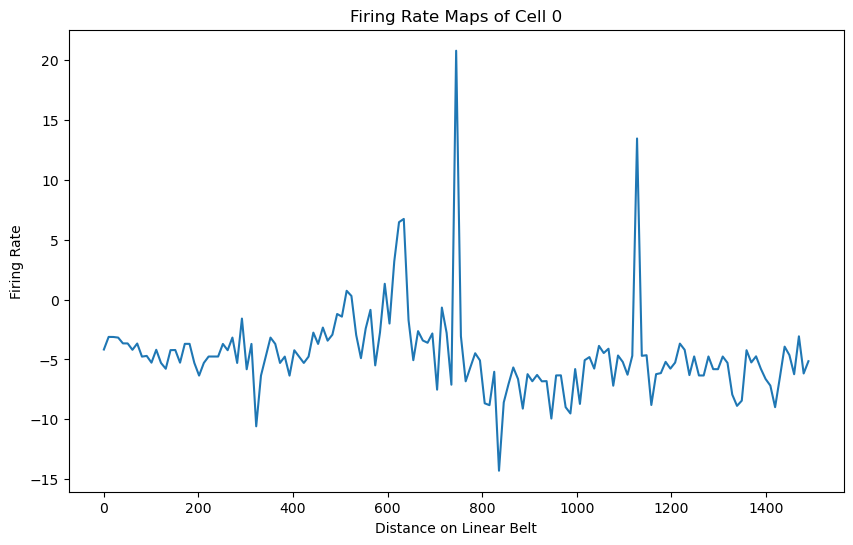

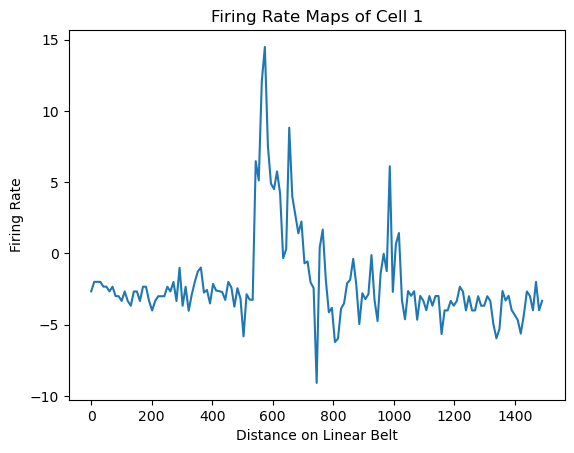

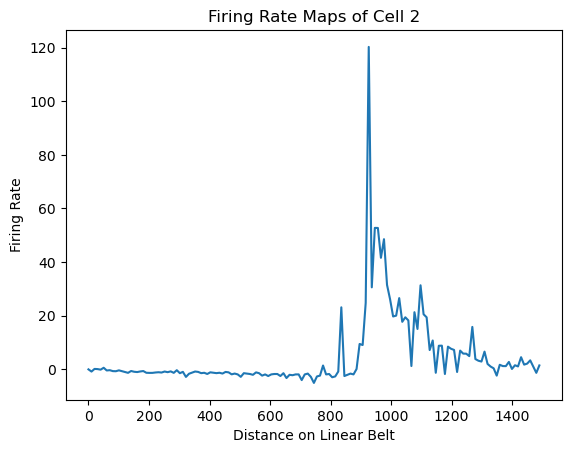

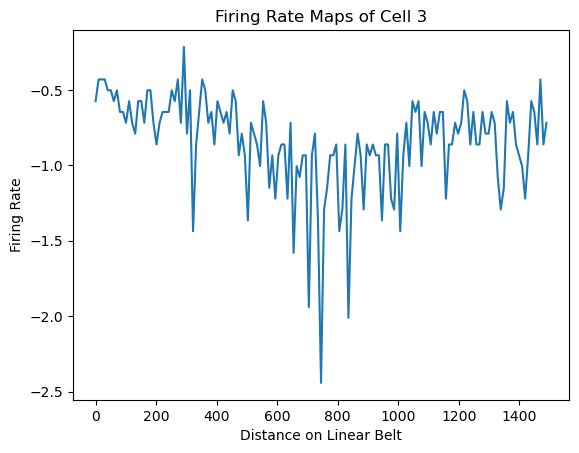

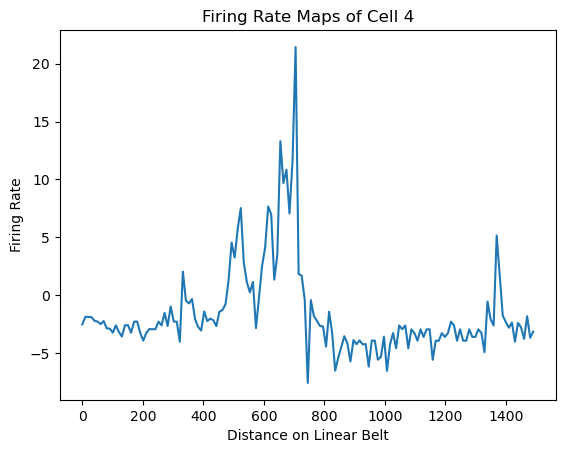

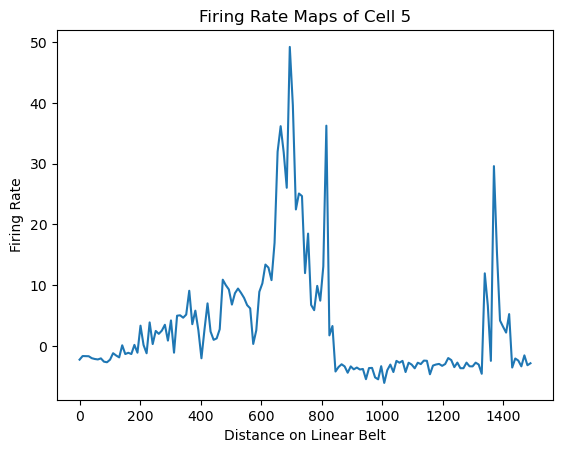

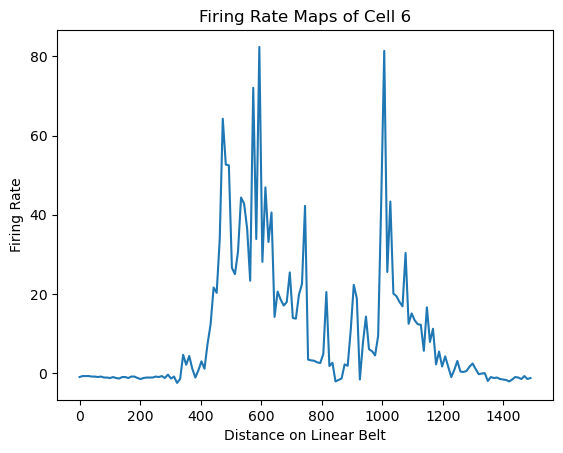

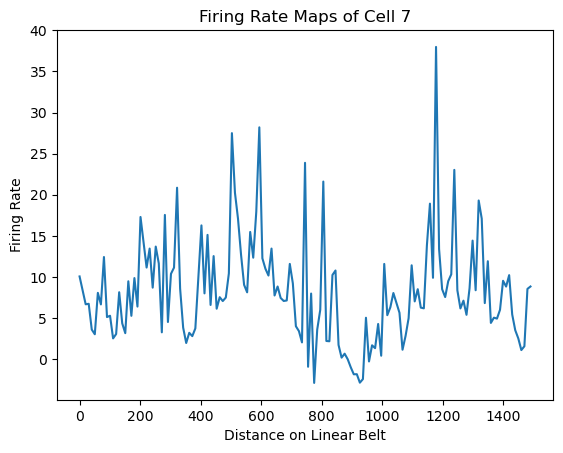

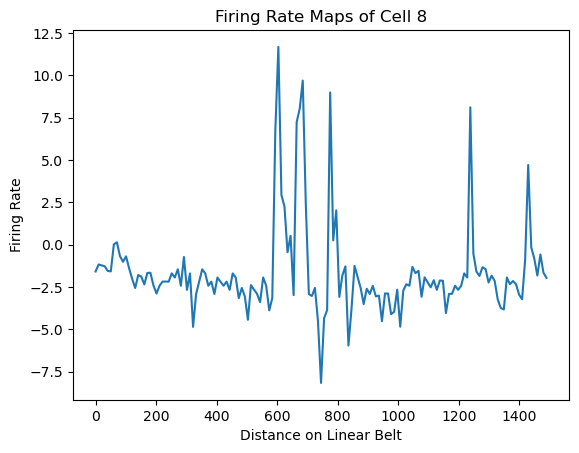

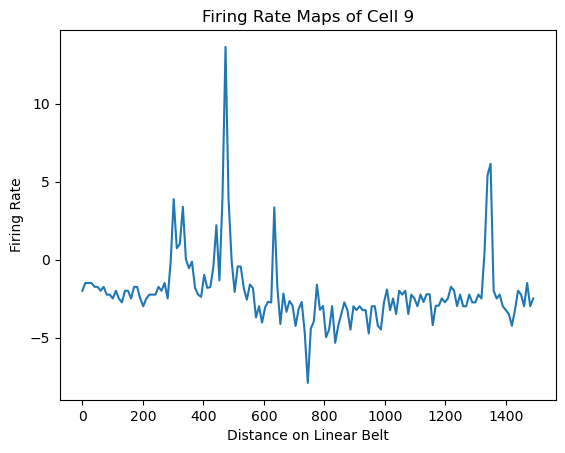

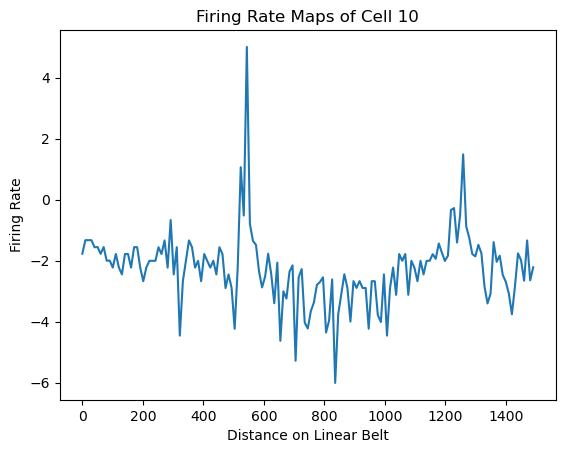

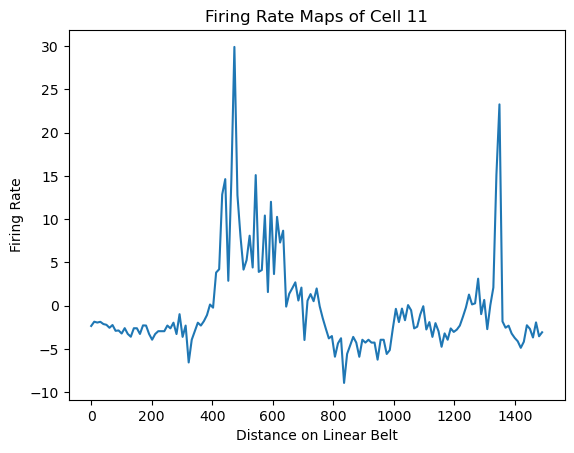

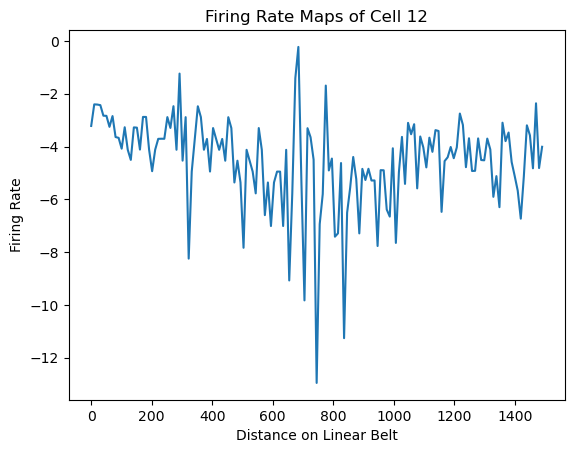

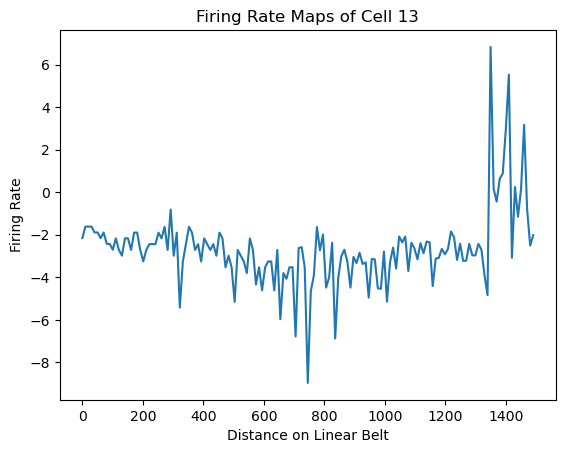

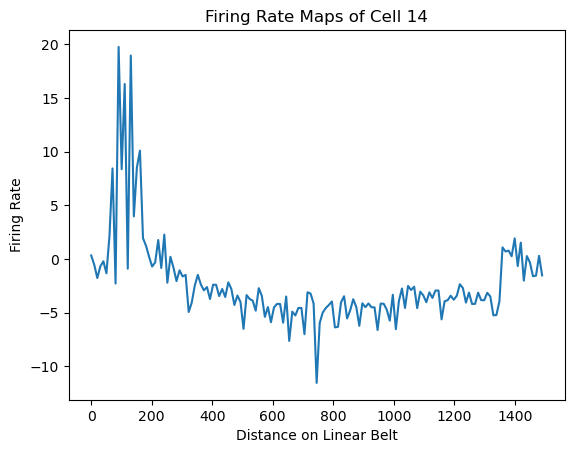

In [23]:
# Extract relevant columns
fluorescence_traces = data.iloc[:, :592]  # Columns containing fluorescence traces
distance = data.iloc[:, 594]  # Column containing distance on the linear belt
speed = data.iloc[:, 595]  # Column containing speed
rounds = data.iloc[:, 596]  # Column containing the number of rounds
running = data.iloc[:, 597]  # Column containing running status

# Step 2: Calculate spatial firing rate maps
def calculate_firing_rate_map(fluorescence_traces, distance_bins):
    firing_rate_maps = []
    for i in range(len(fluorescence_traces.columns)):
        firing_rate_map, _ = np.histogram(distance, bins=distance_bins, weights=fluorescence_traces.iloc[:, i])
        firing_rate_maps.append(firing_rate_map)
    return np.array(firing_rate_maps)

# Define distance bins
distance_bins = np.linspace(distance.min(), distance.max(), num=150)

# Calculate firing rate maps
firing_rate_maps = calculate_firing_rate_map(fluorescence_traces, distance_bins)

# Visualize firing rate maps
plt.figure(figsize=(10, 6))
for i in range(15):#len(firing_rate_maps)):
    plt.plot(distance_bins[:-1], firing_rate_maps[i], label=f'Cell {i+1}')
    plt.xlabel('Distance on Linear Belt')
    plt.ylabel('Firing Rate')
    plt.title(f'Firing Rate Maps of Cell {i}')
    #plt.legend(loc='lower right')
    plt.show()


In [24]:
#isolate the firing maps where there is at least one event:

cells_with_events=[]
num_of_cells=592
for i in range(num_of_cells):
    if len(event_numbers(data[i],4,20))>3:
        cells_with_events.append(i)

In [25]:
len(cells_with_events)

328

plotting and storing all the cells in one pdf file. this is before any place cell identiciation
also it is not averaging it is about summing the activations

C:\Users\Theodore Tamiolakis\AppData\Local\Temp\ipykernel_25236\1369792802.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 8))


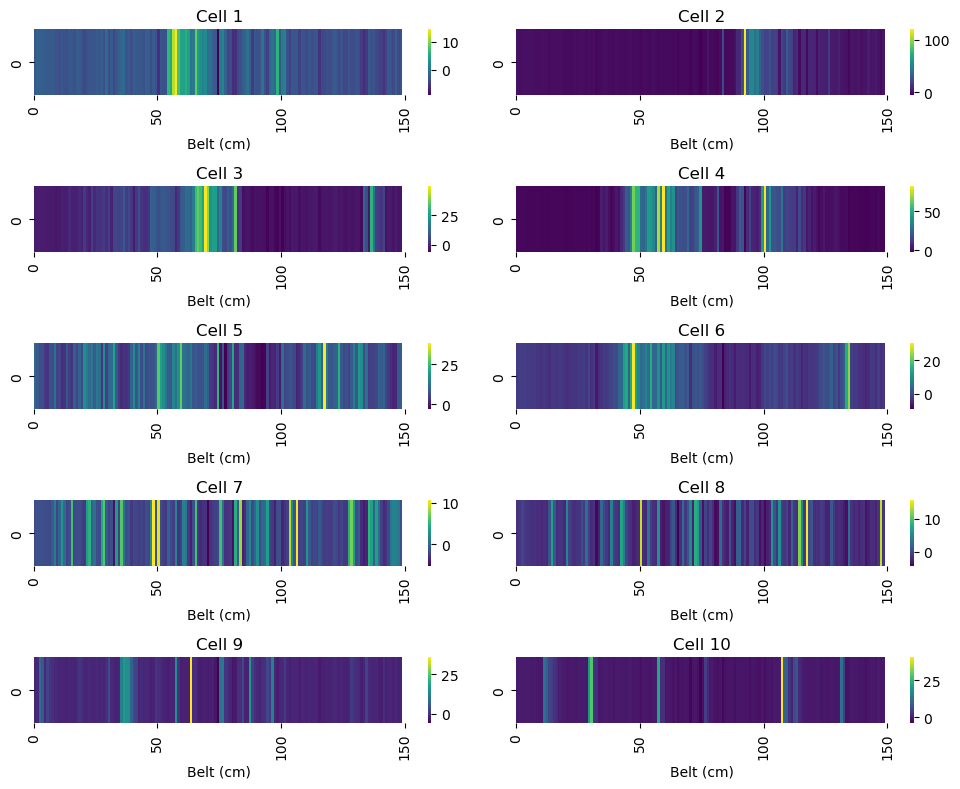

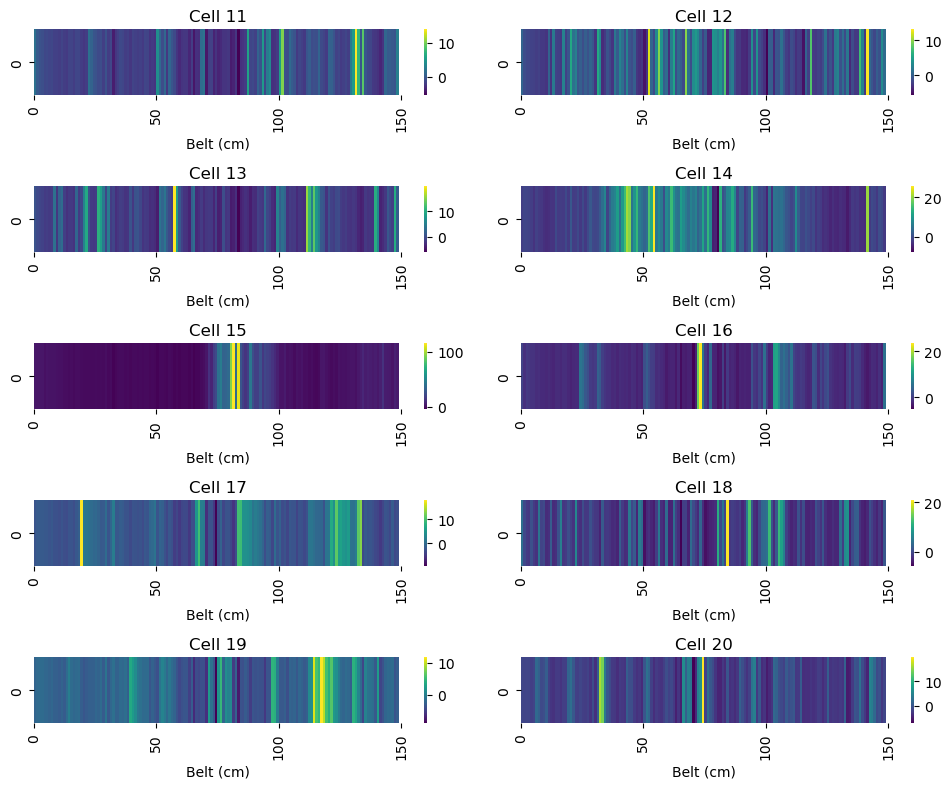

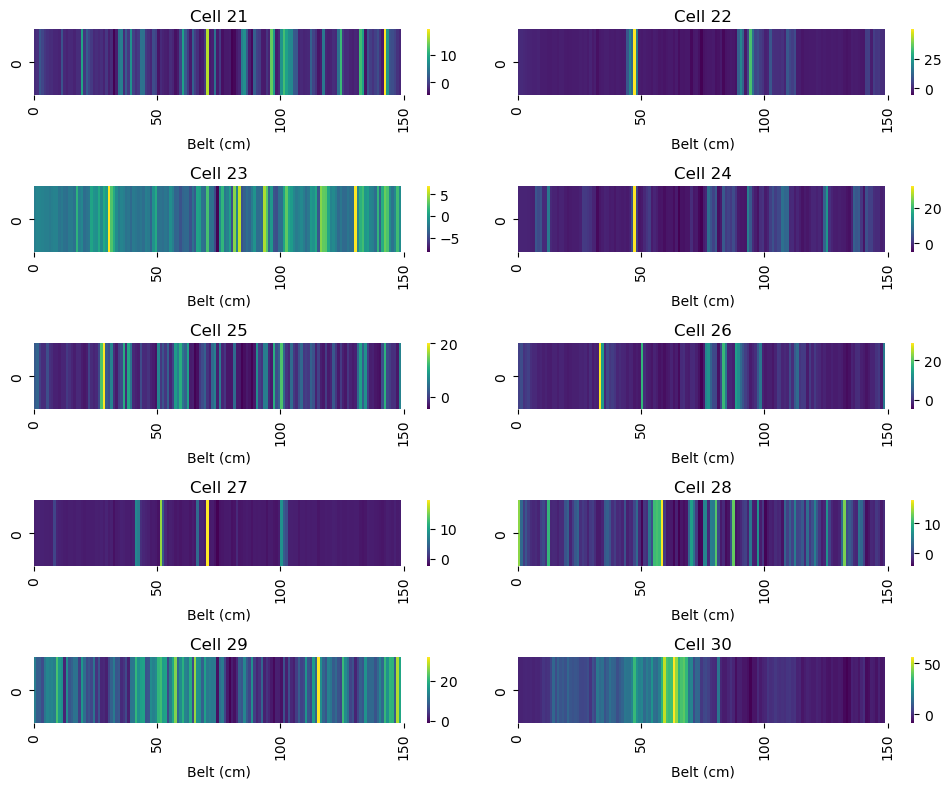

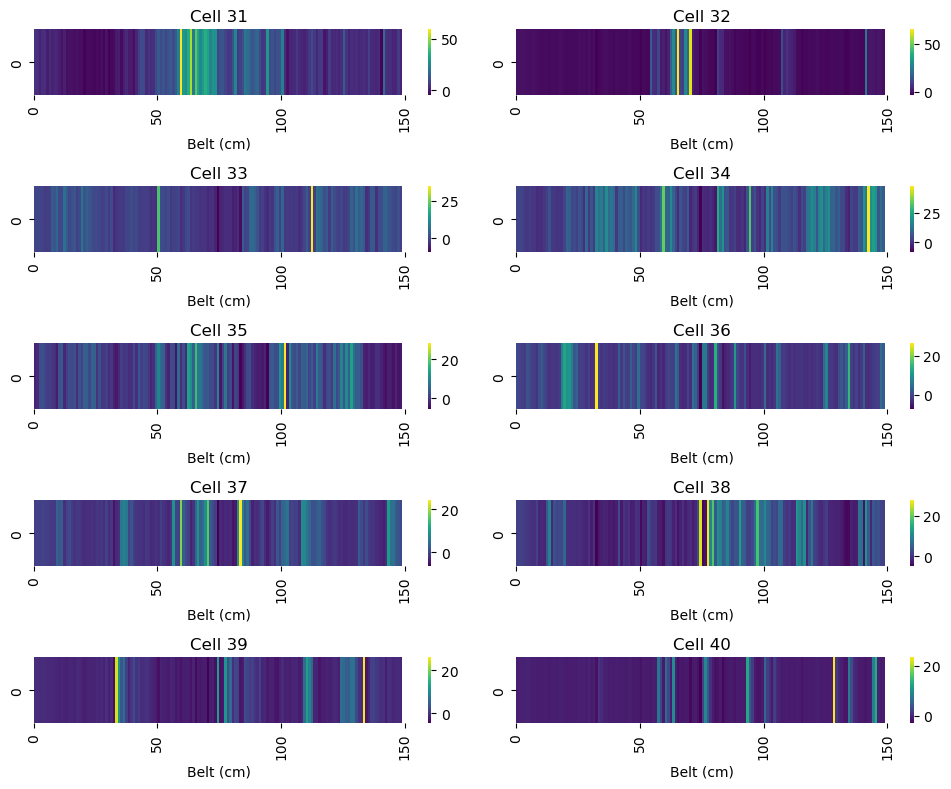

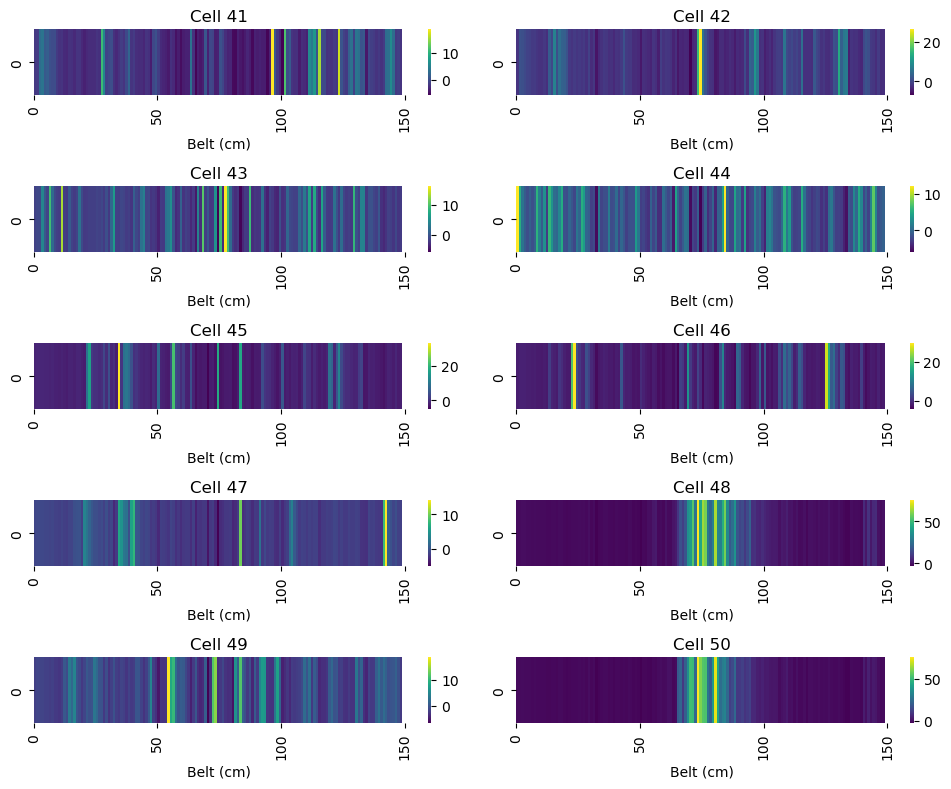

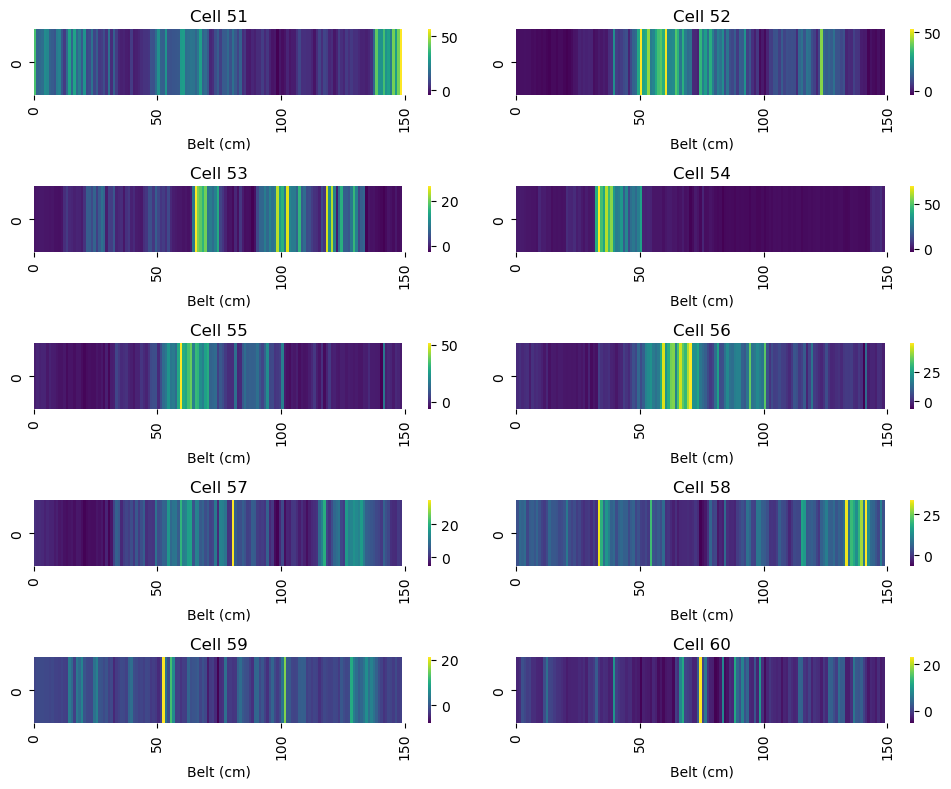

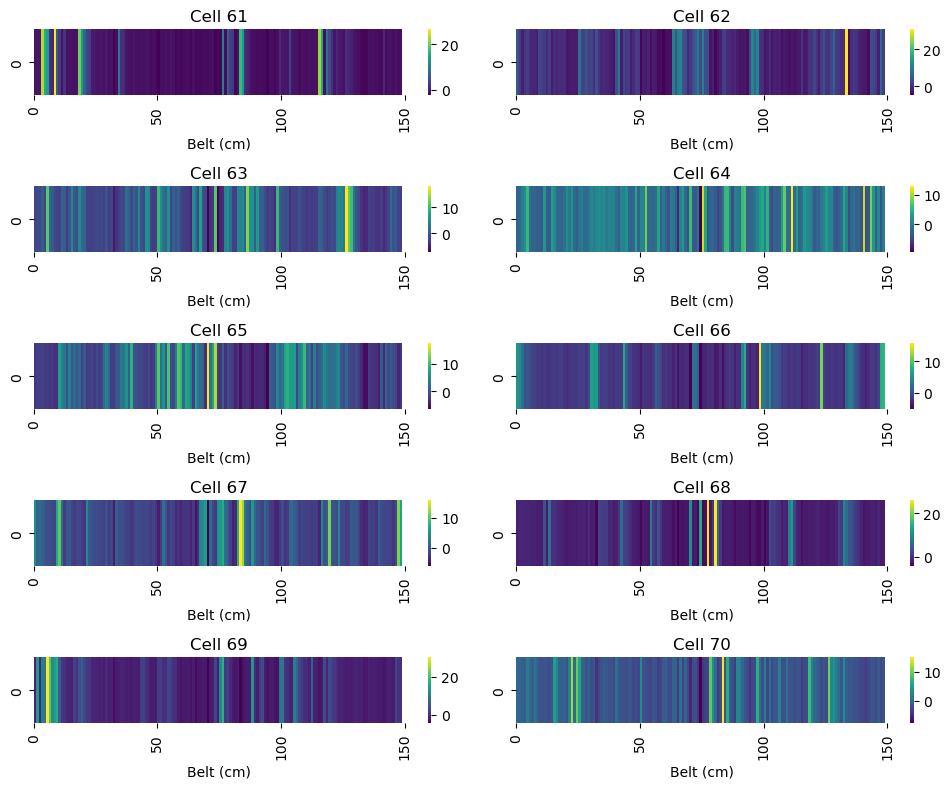

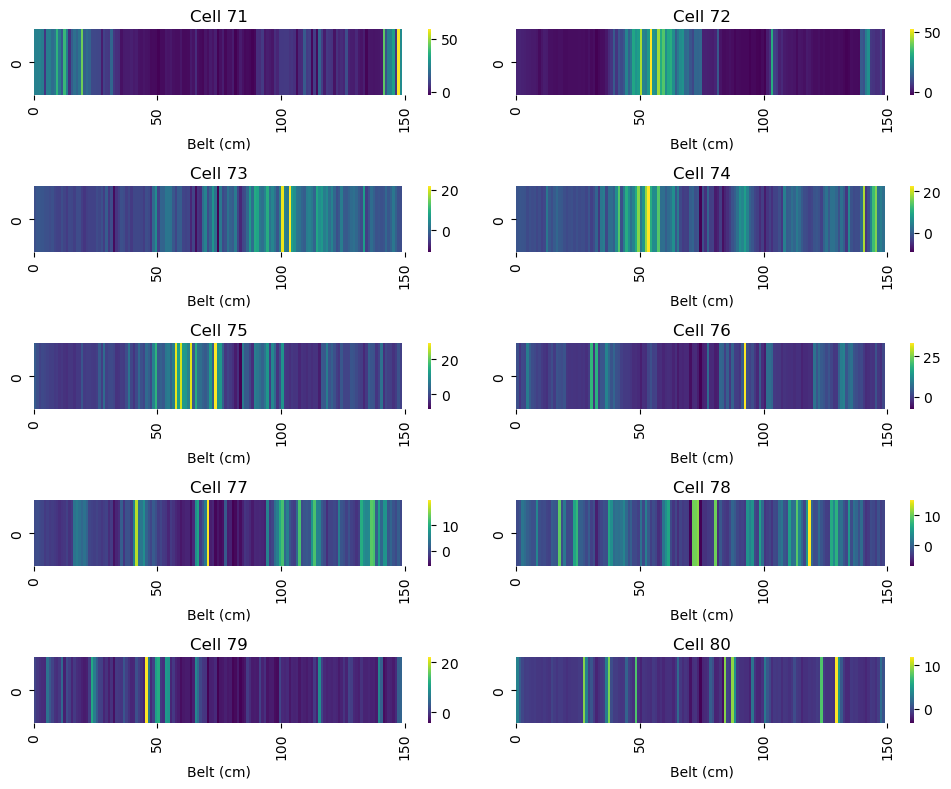

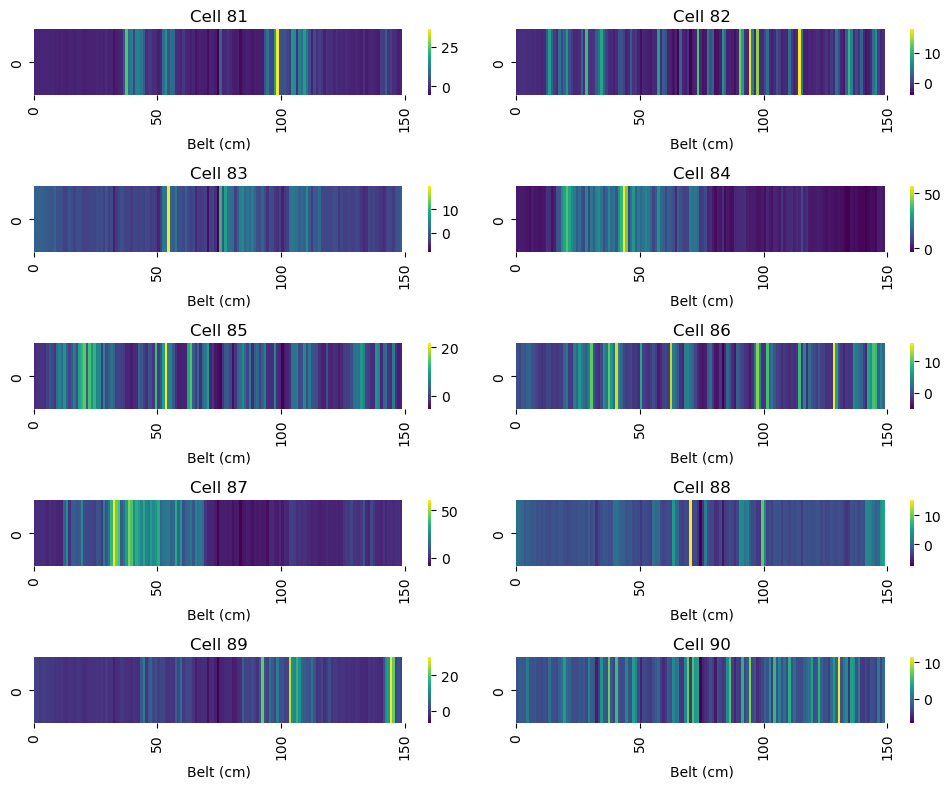

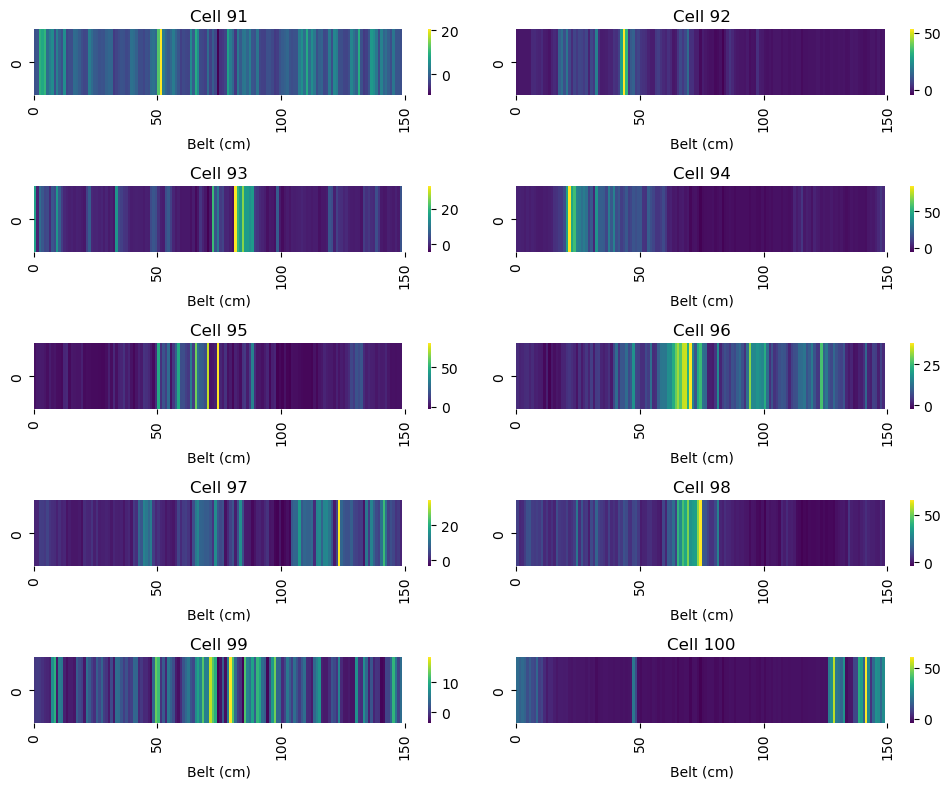

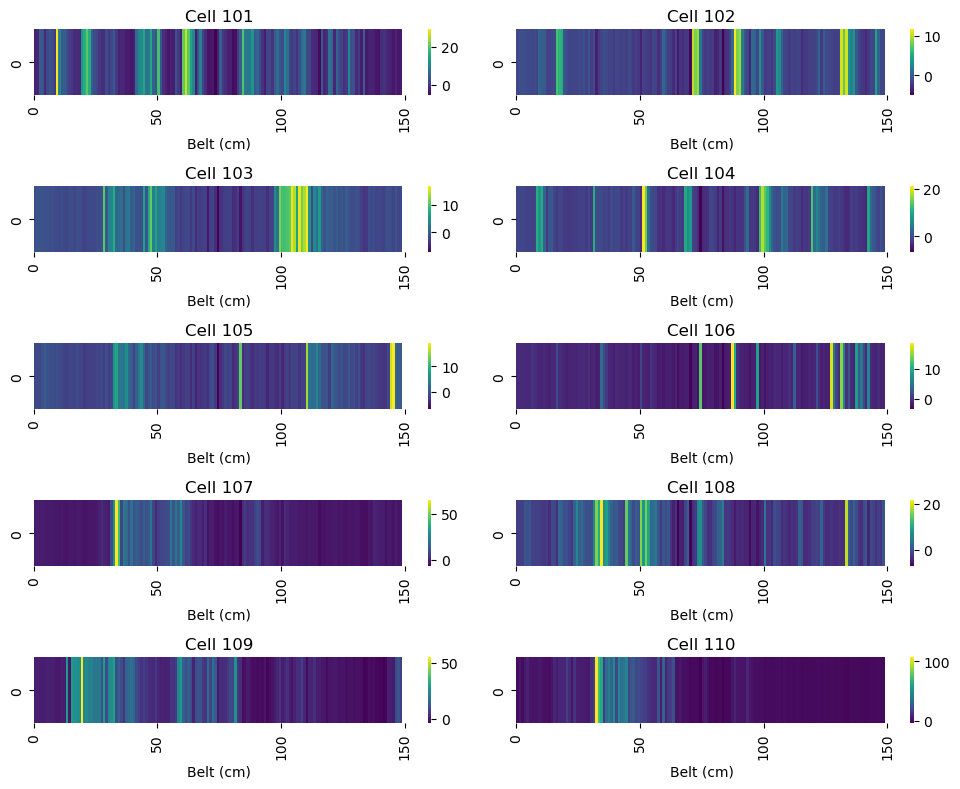

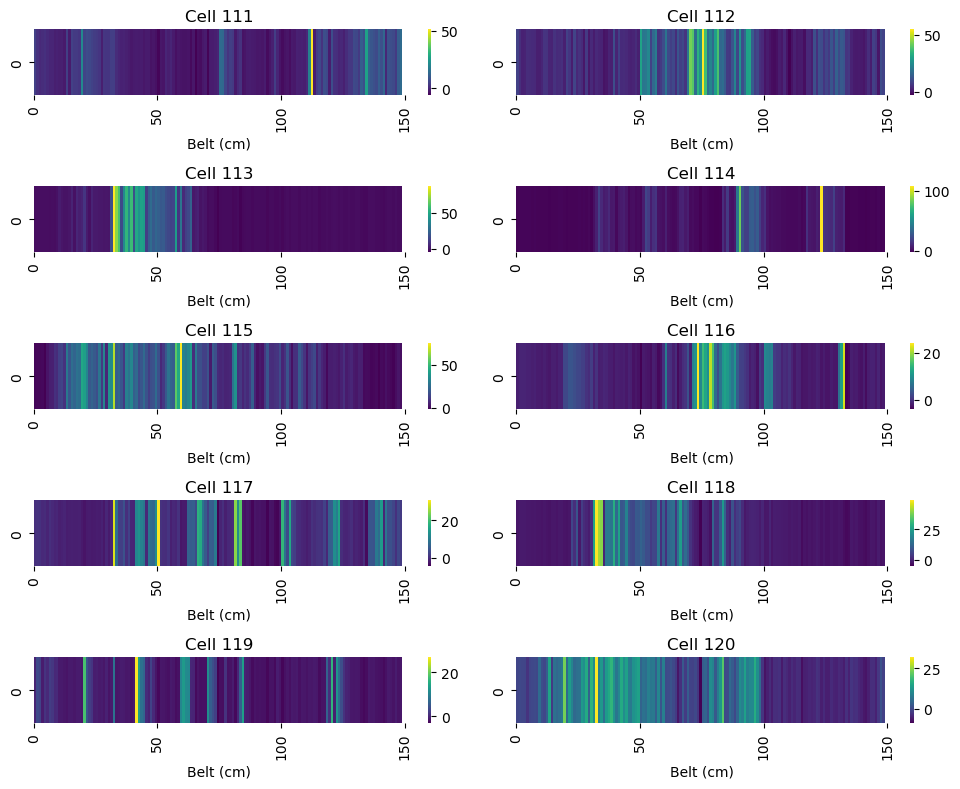

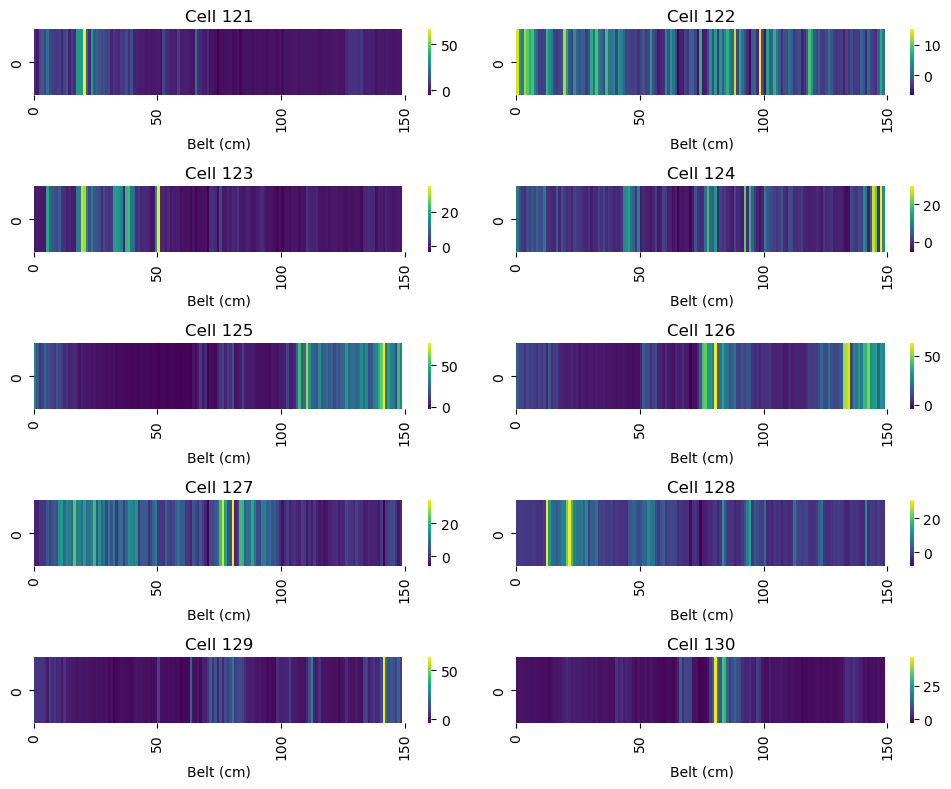

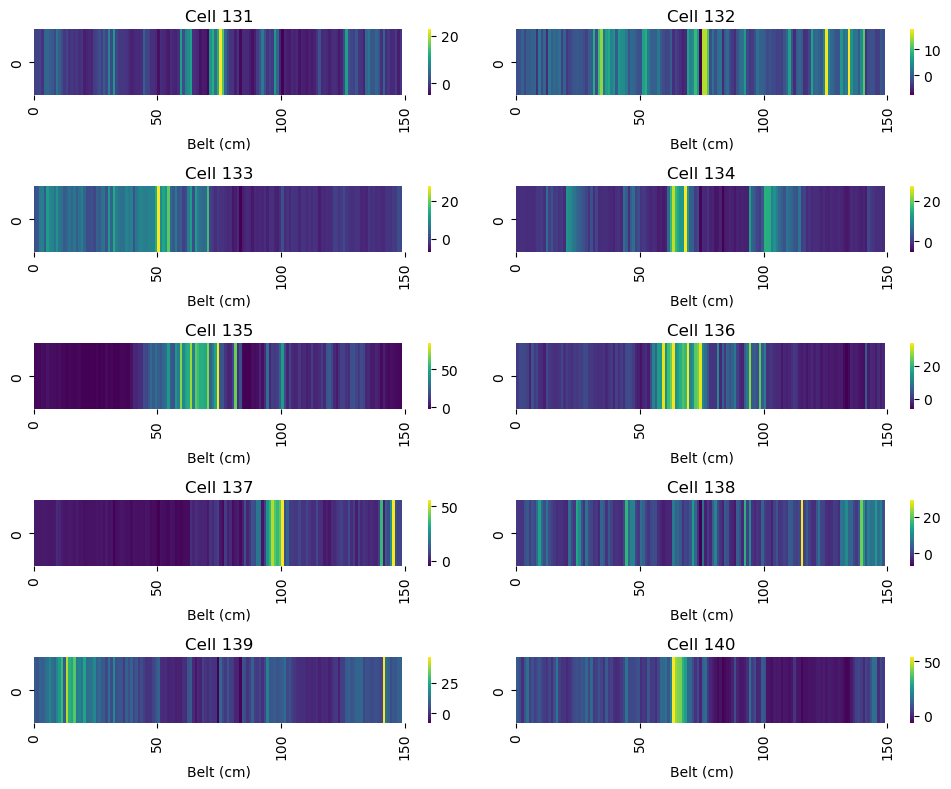

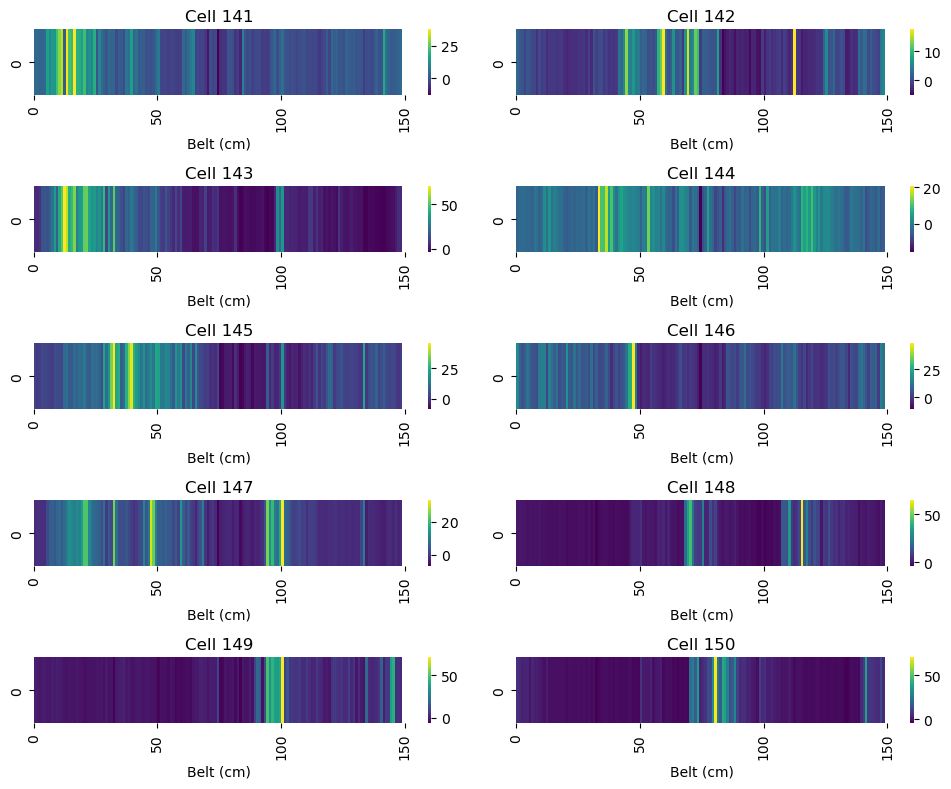

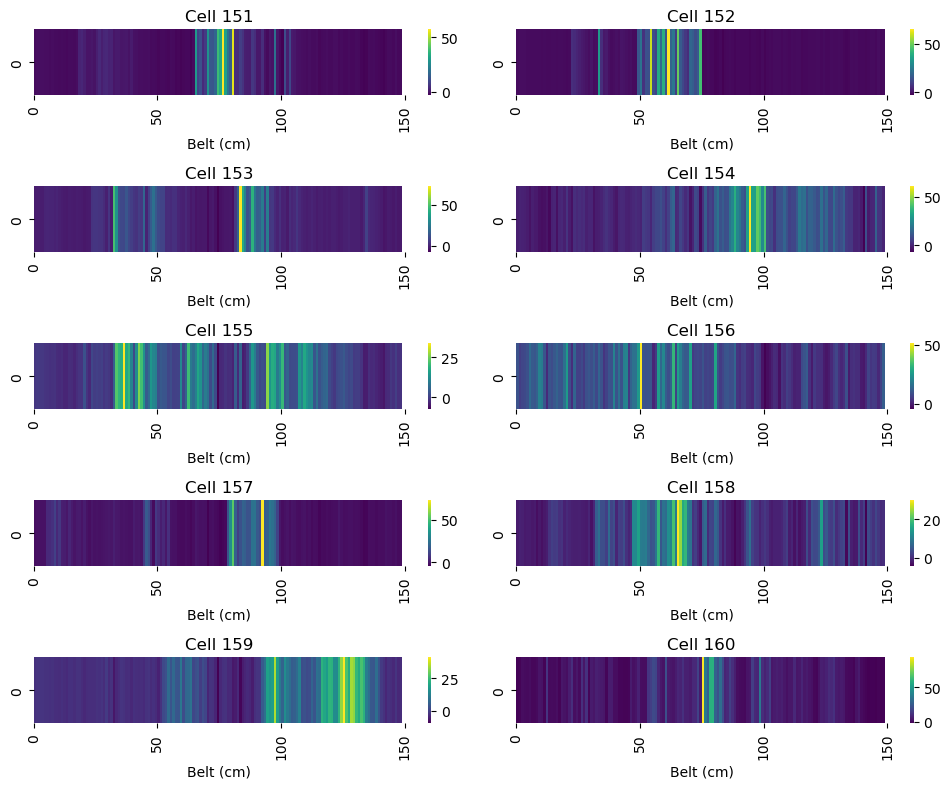

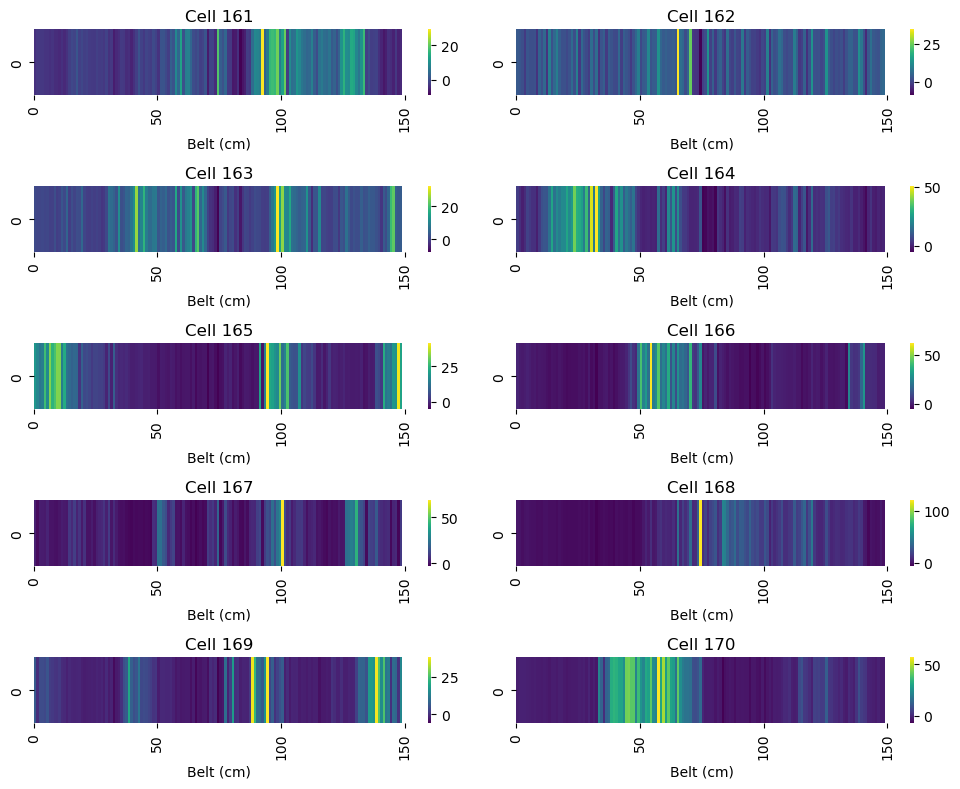

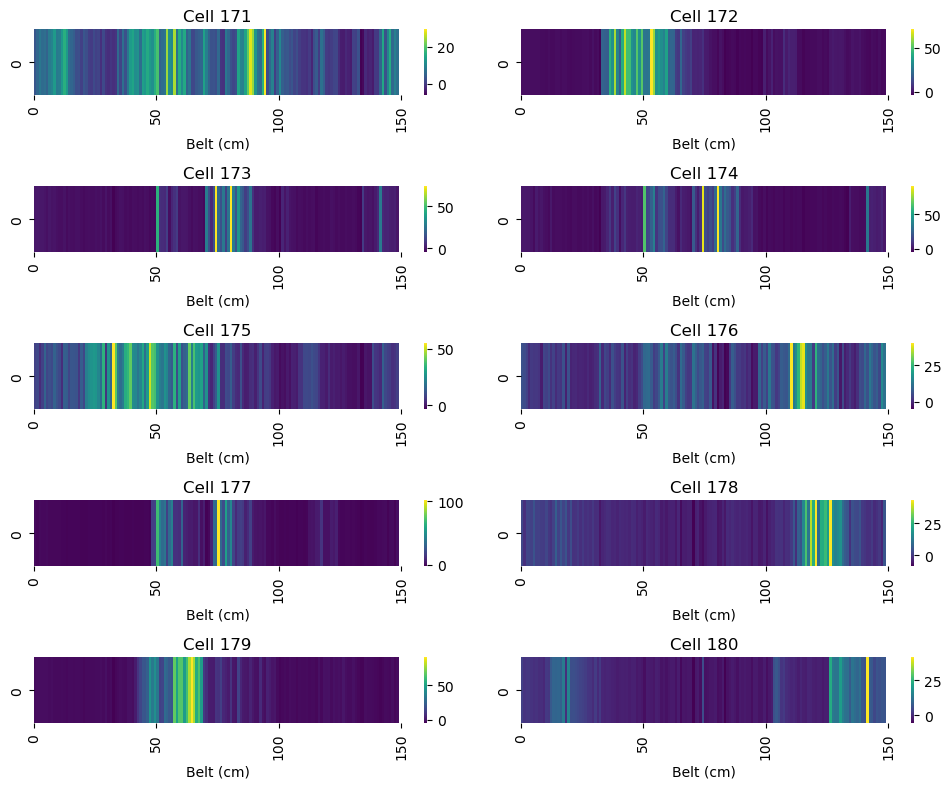

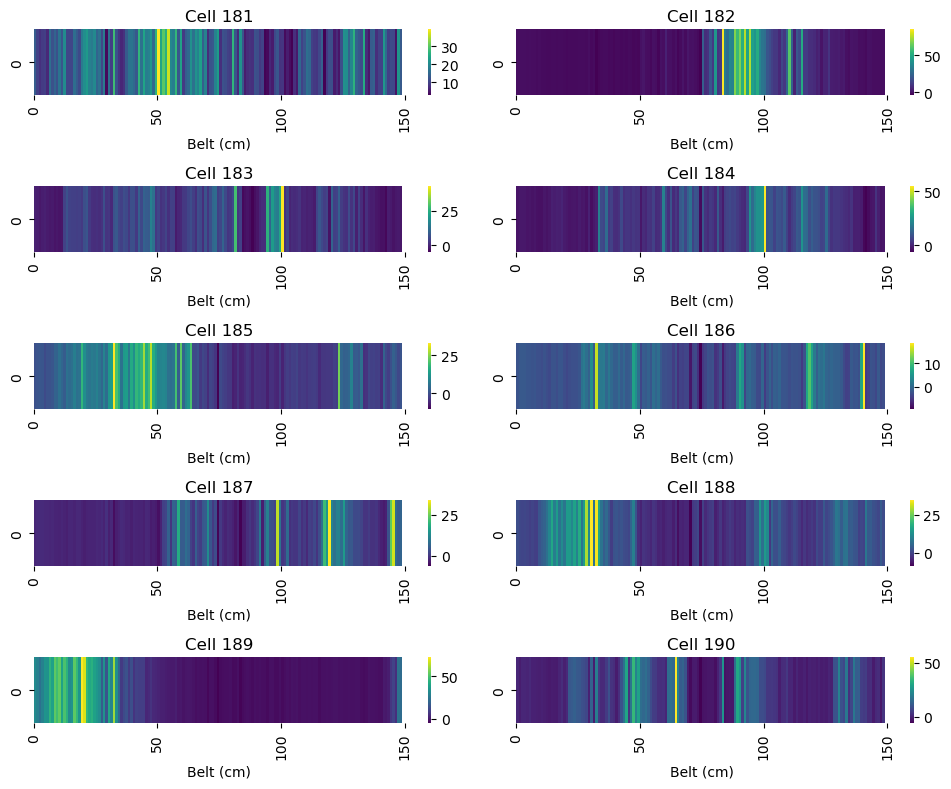

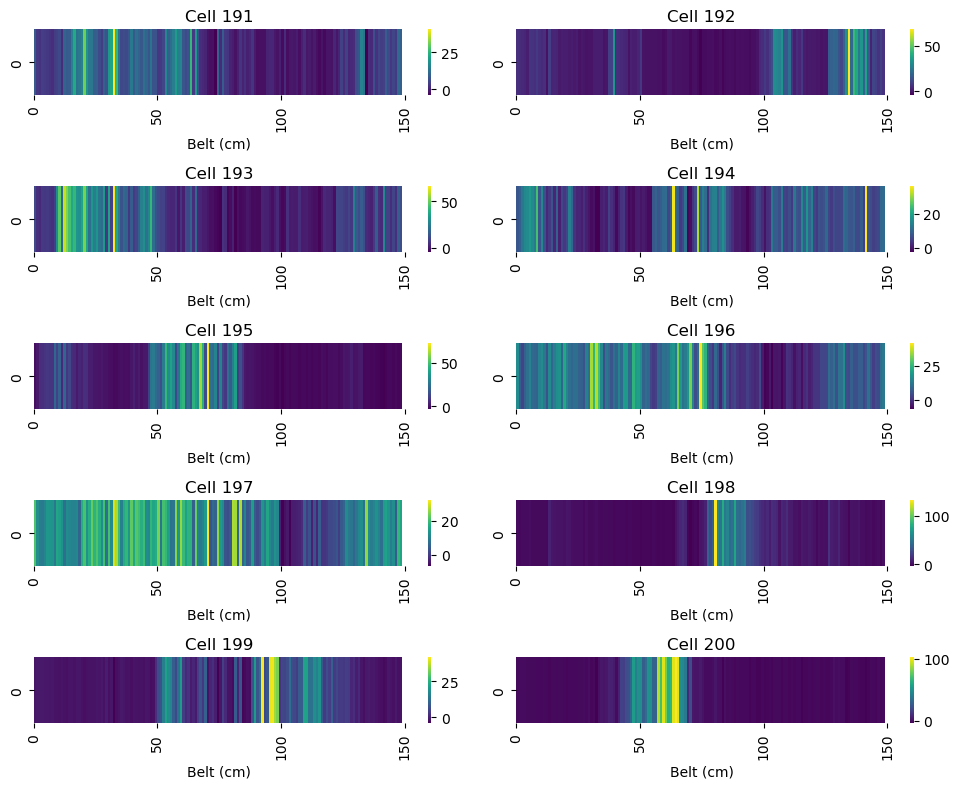

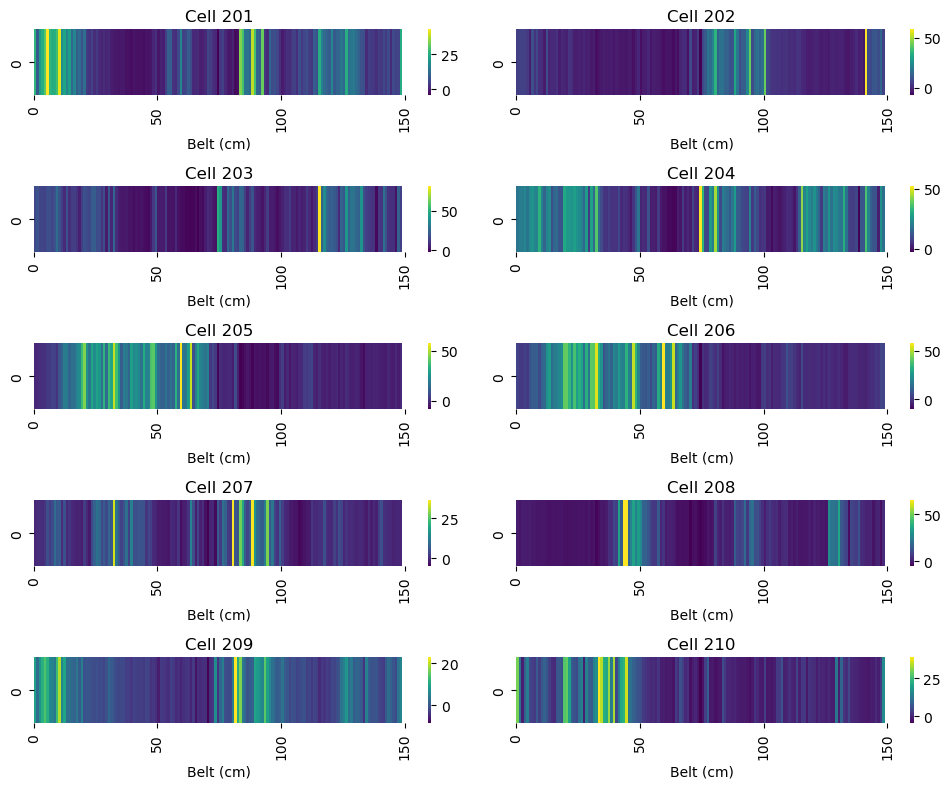

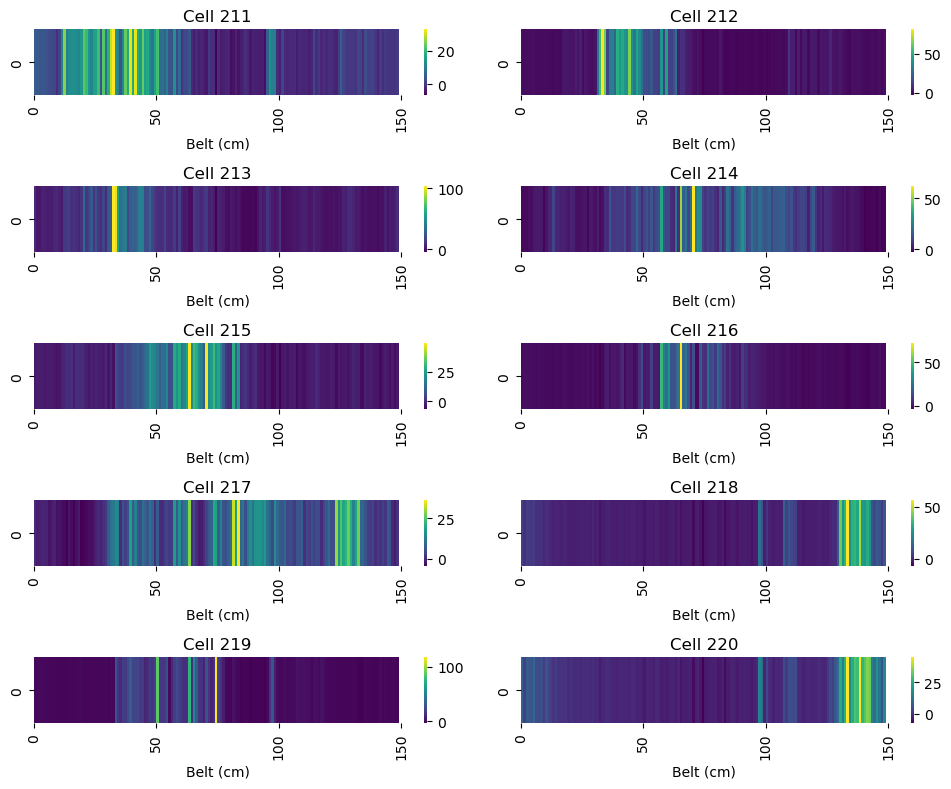

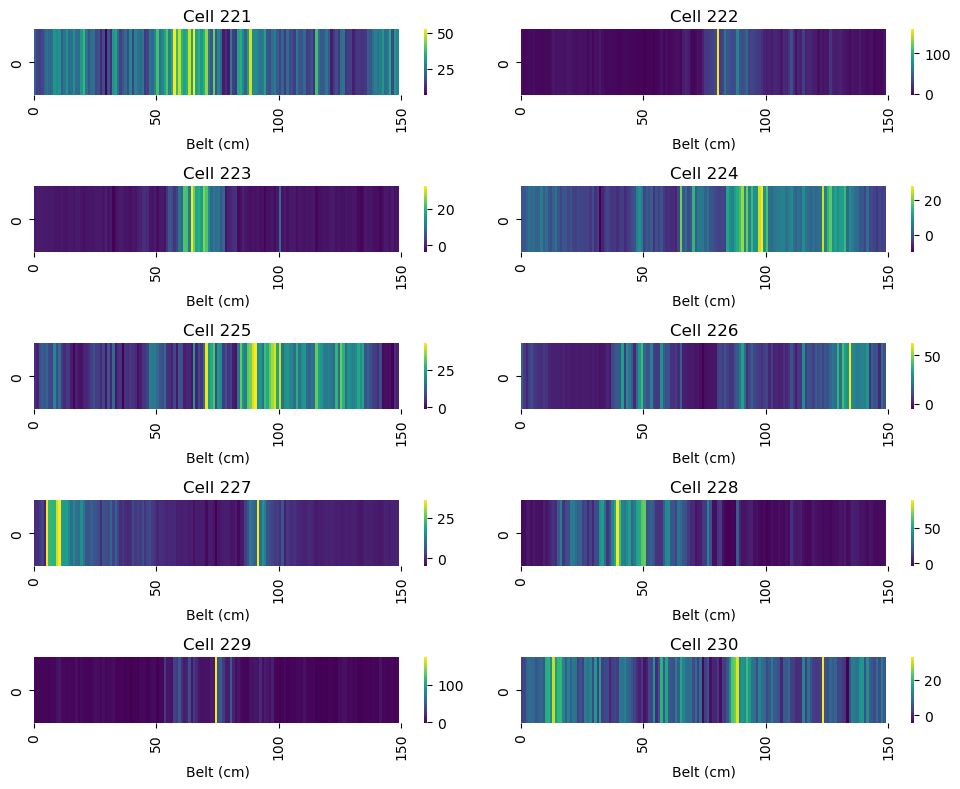

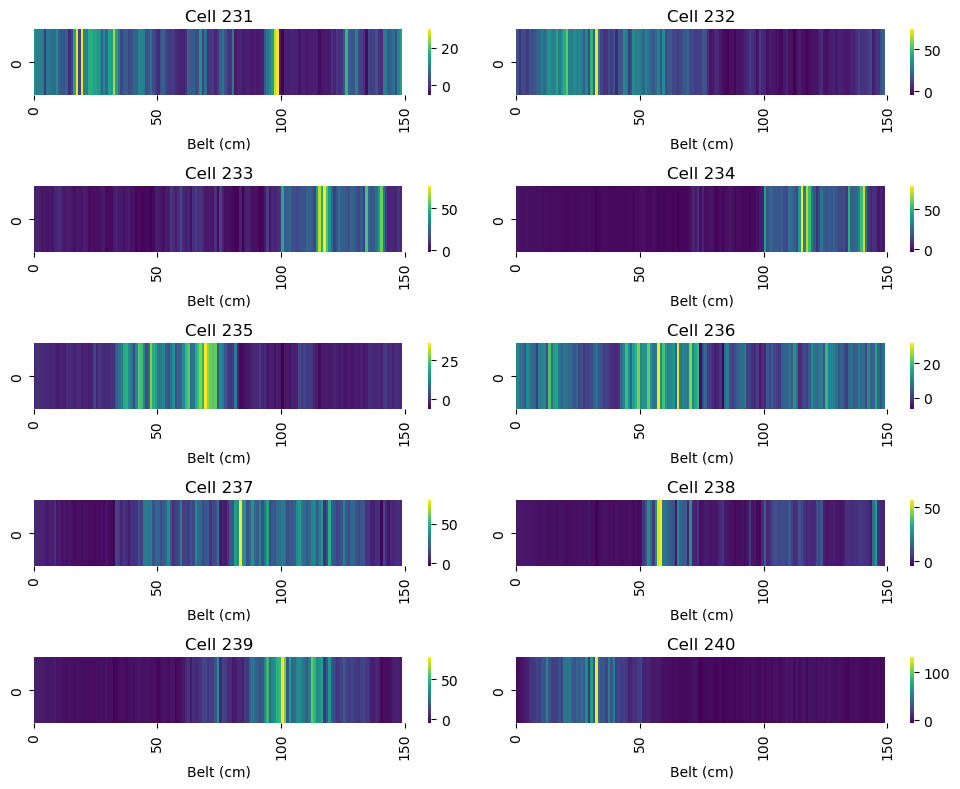

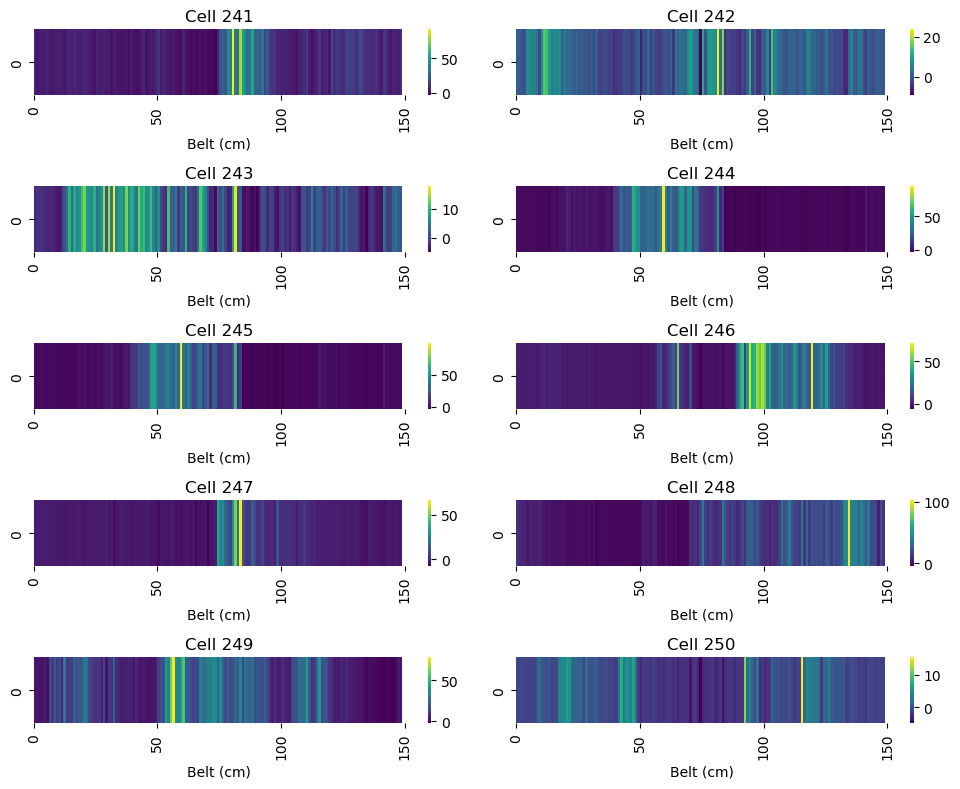

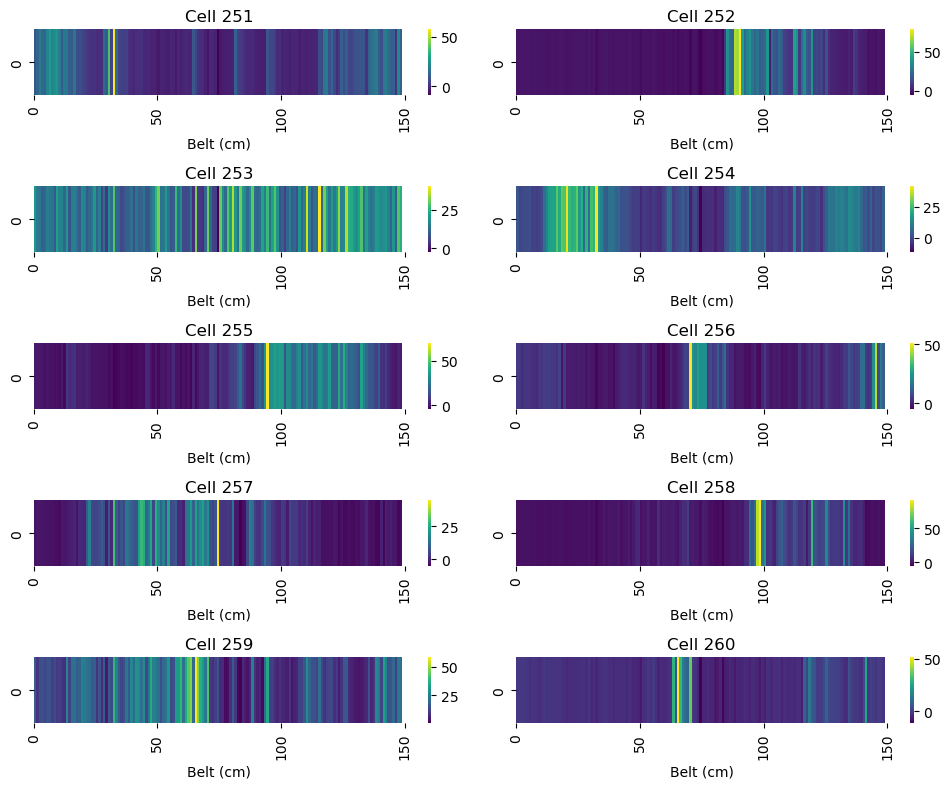

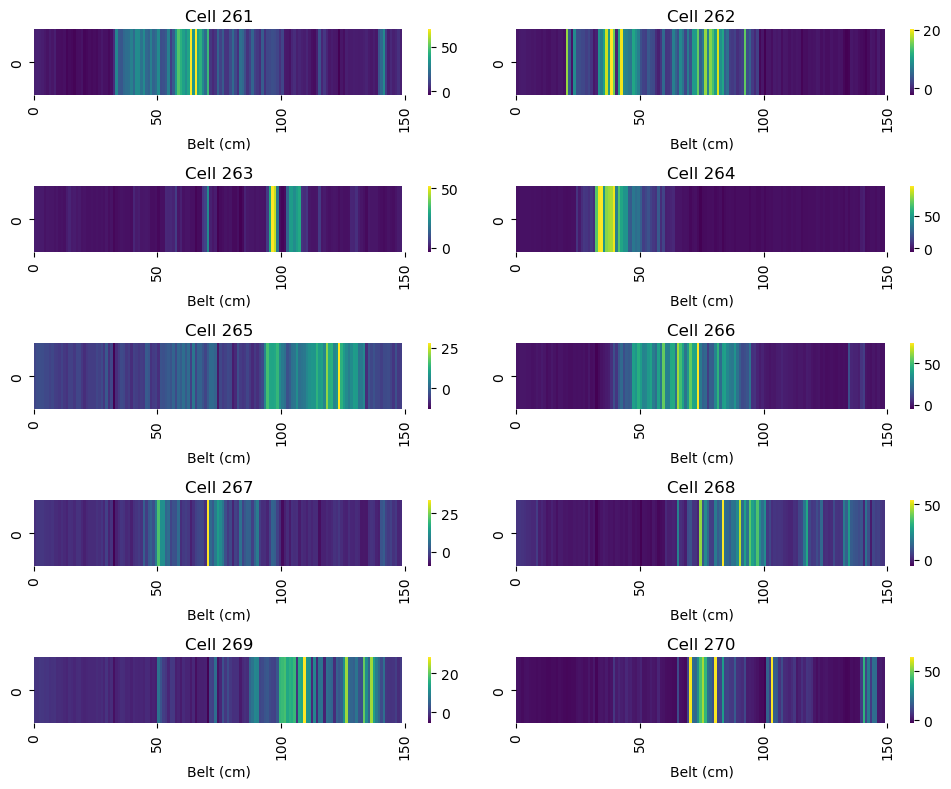

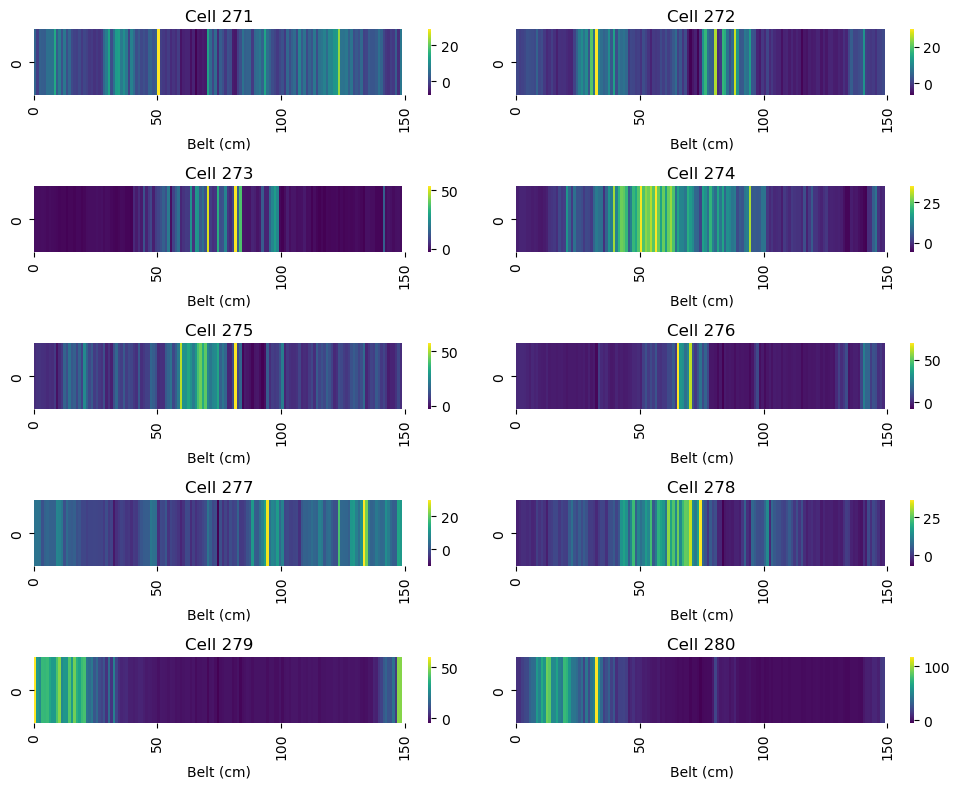

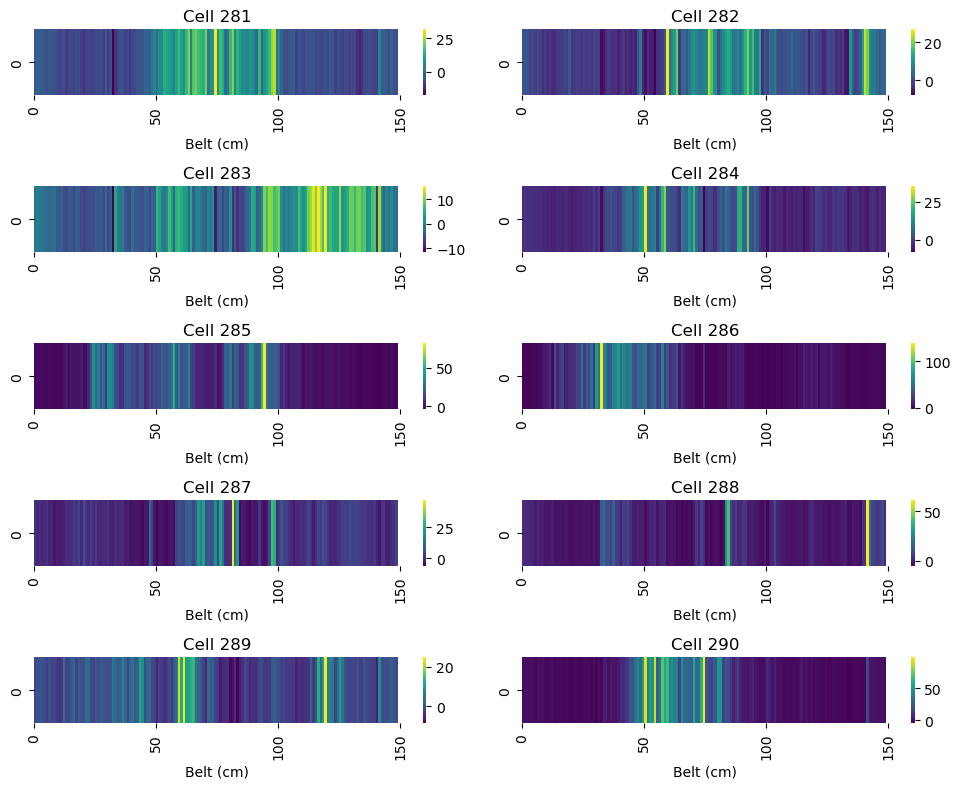

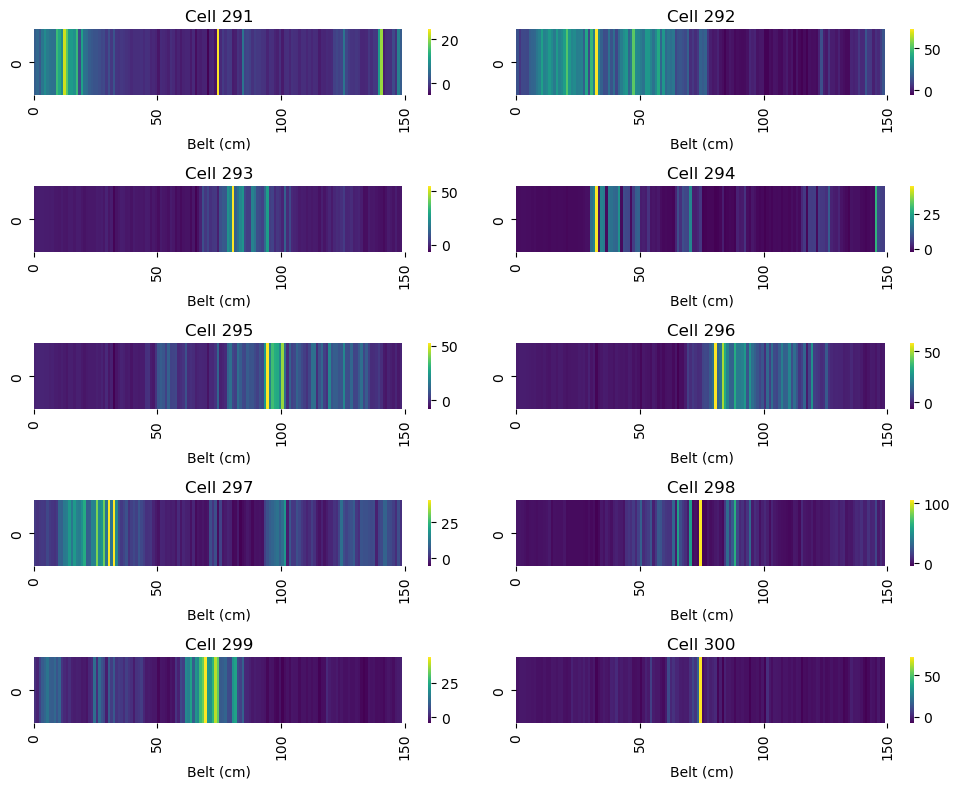

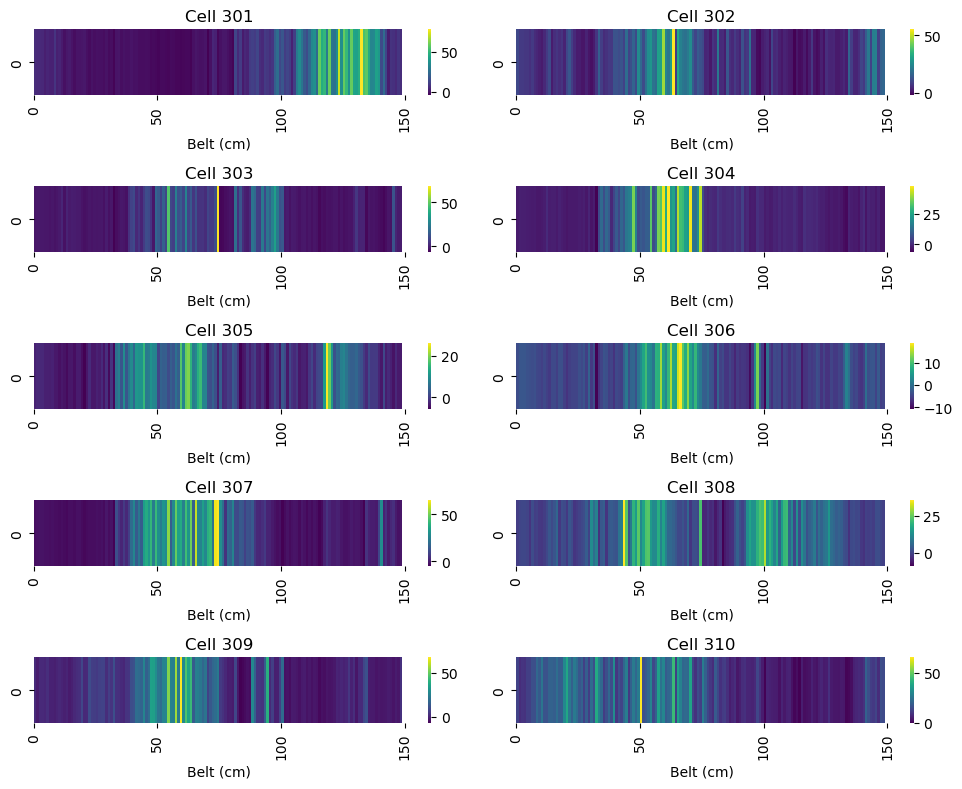

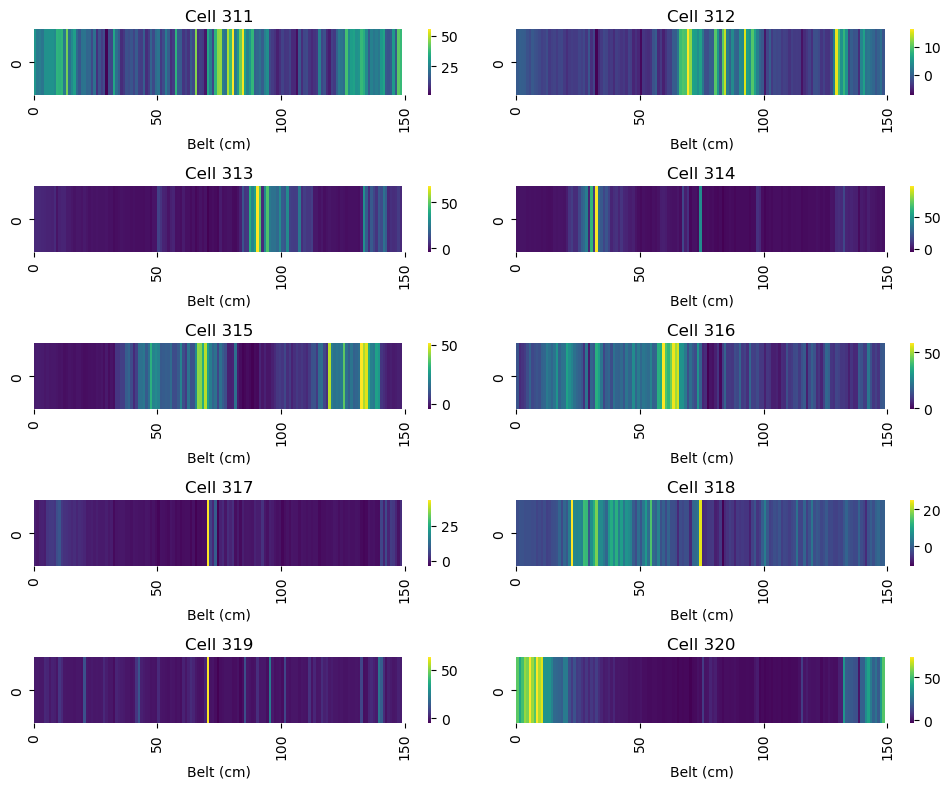

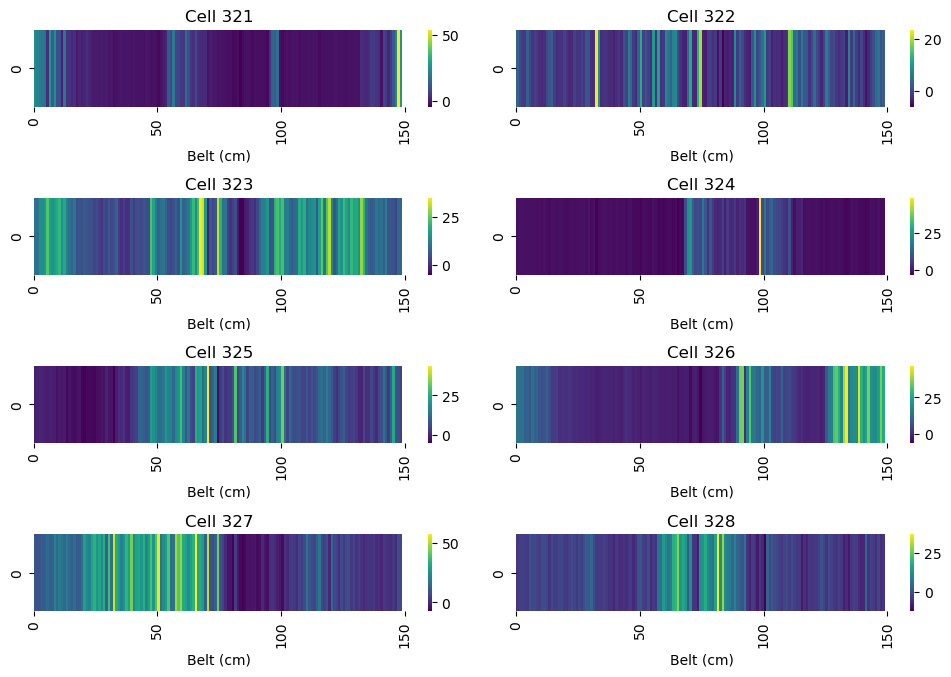

In [26]:
from matplotlib.backends.backend_pdf import PdfPages

# Assuming firing_rate_maps[2] is the data for a single cell's firing rate map
# Set the number of subplots per page
subplots_per_page = 10

#firing map with events
firing_rate_maps=firing_rate_maps[cells_with_events]
# Calculate the number of pages needed
num_pages = int(np.ceil(len(firing_rate_maps) / subplots_per_page))

# Create a PDF file
pdf_pages = PdfPages(results_folder+'heatmap_with_events.pdf')

for page in range(num_pages):
    # Create a new figure for each page
    plt.figure(figsize=(10, 8))

    # Add subplots to the page
    for i in range(subplots_per_page):
        idx = page * subplots_per_page + i
        if idx < len(firing_rate_maps):
            firing_rate_map = np.atleast_2d(firing_rate_maps[idx])
            # Add subplot for the current cell's firing rate map
            plt.subplot(5, 2, i + 1)  # Assuming 20 subplots arranged in 4x5 grid
            sns.heatmap(firing_rate_map, cmap='viridis')
                # Create heatmap using Seaborn with custom x-axis tick labels

            # Calculate tick locations and labels
            tick_locs = np.linspace(0, 150, num=4)
            tick_labels = [int(tick_locs[i]) for i in range(len(tick_locs))]

            # Set custom x-axis tick locations and labels
            plt.xticks(tick_locs, tick_labels)

            # Set labels and title
            plt.xlabel('Belt (cm)')

            plt.title(f'Cell {idx + 1}')

    # Adjust layout and save the page
    plt.tight_layout()
    pdf_pages.savefig()

# Close the PDF file
pdf_pages.close()

plotting the average firing rate map. maybe is better. I will compare it with the other

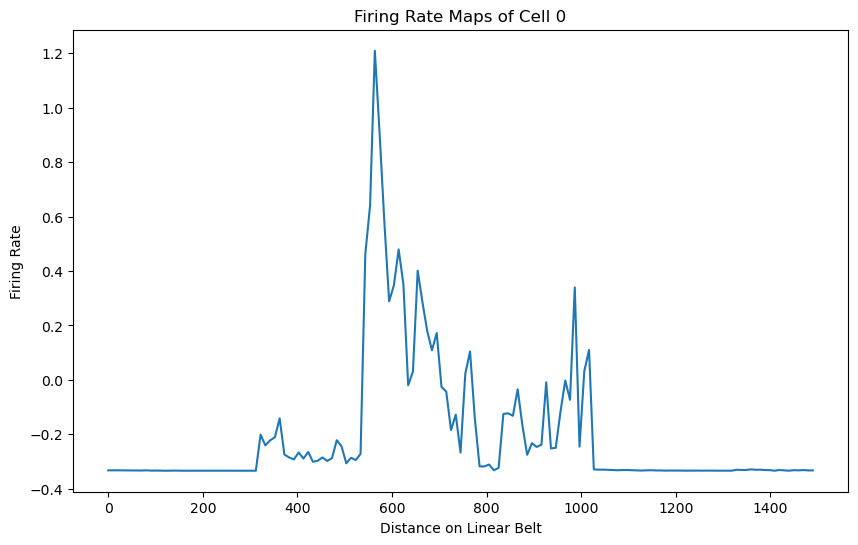

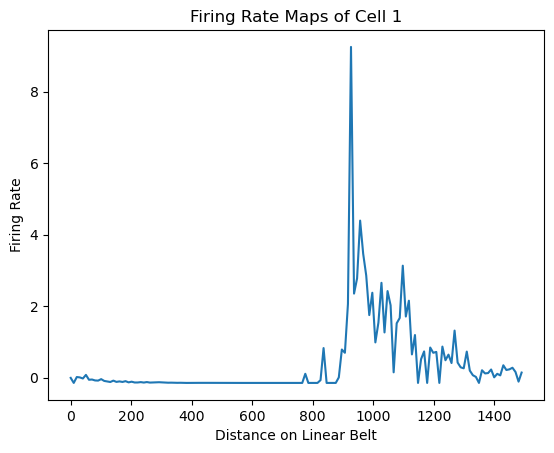

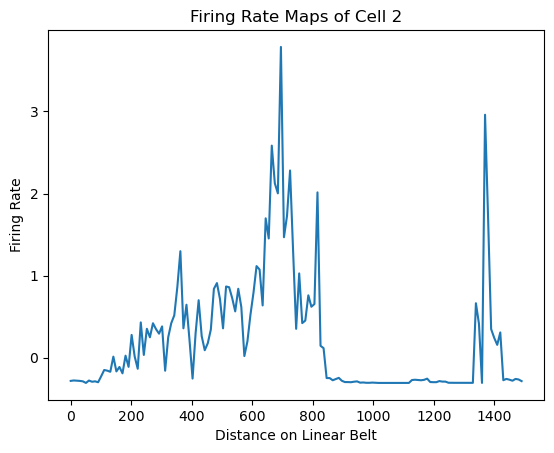

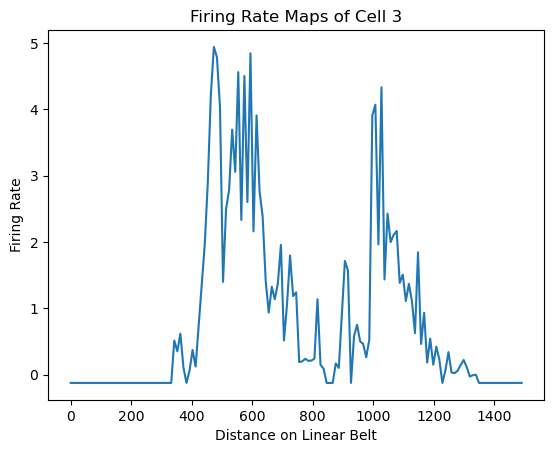

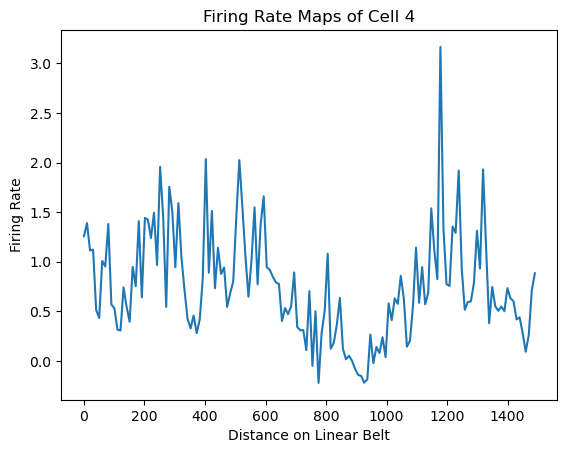

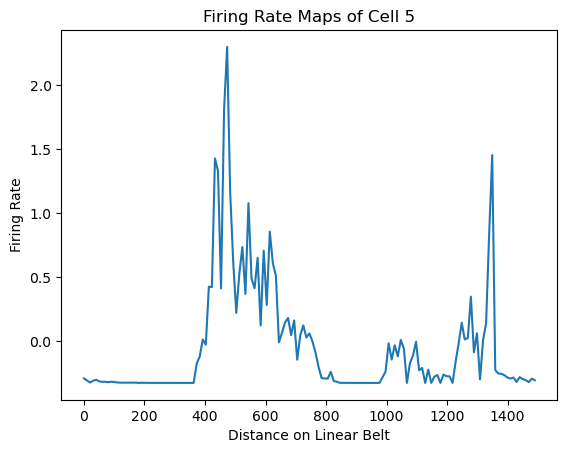

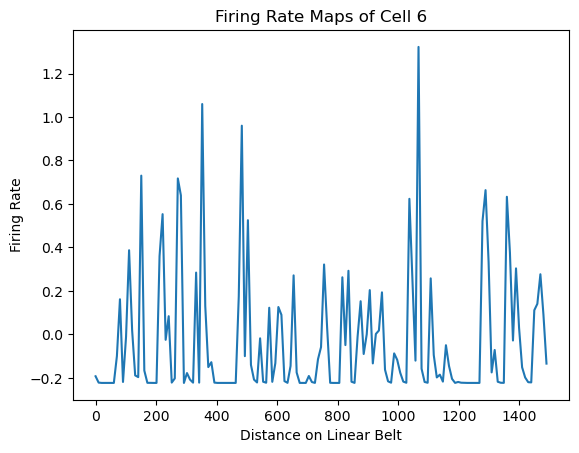

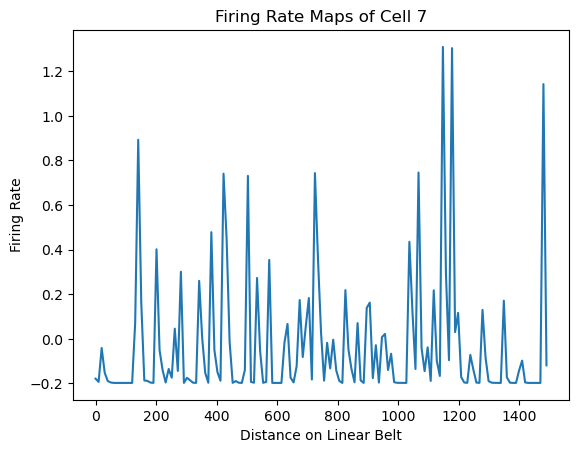

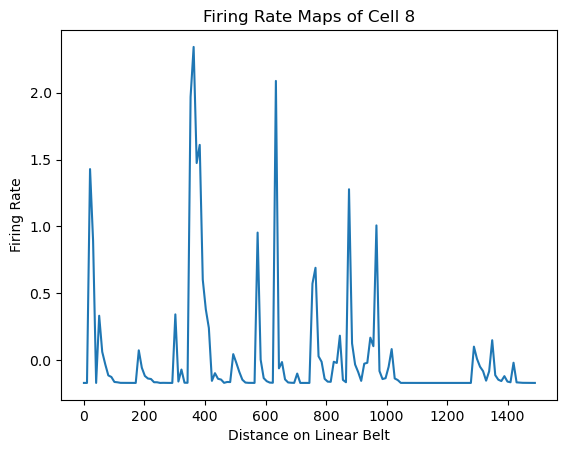

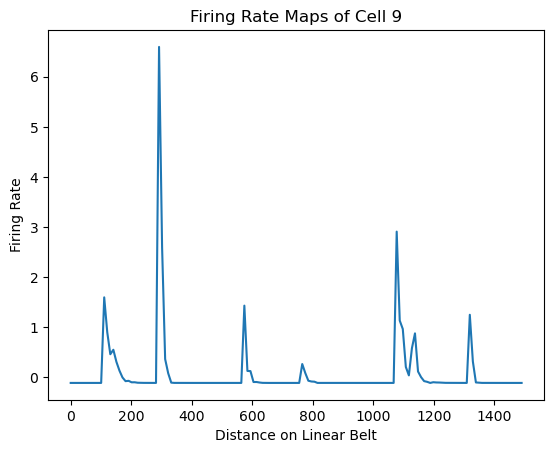

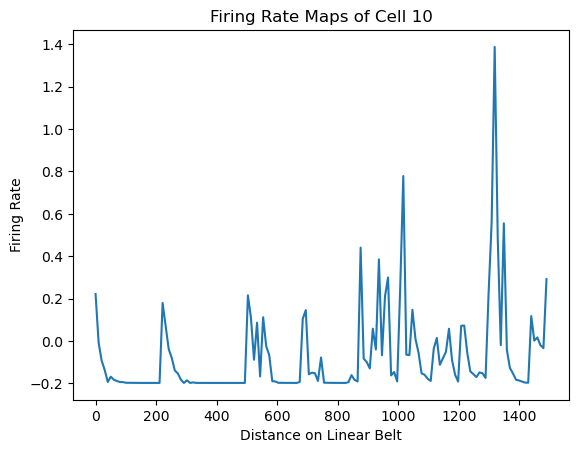

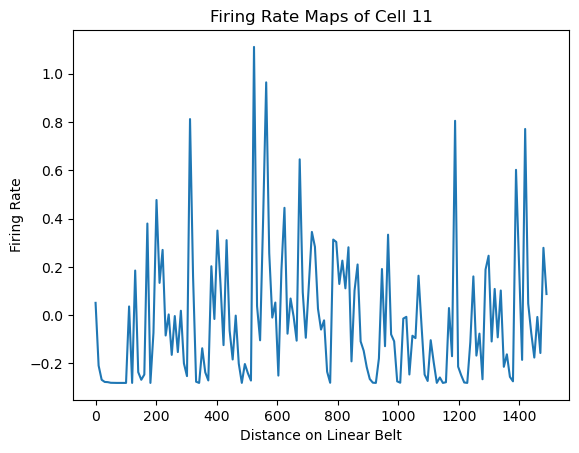

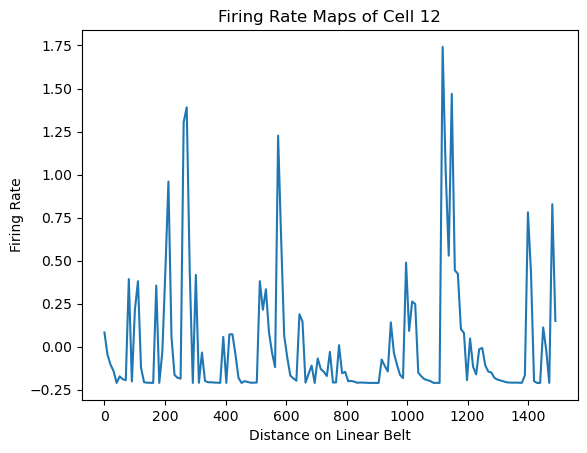

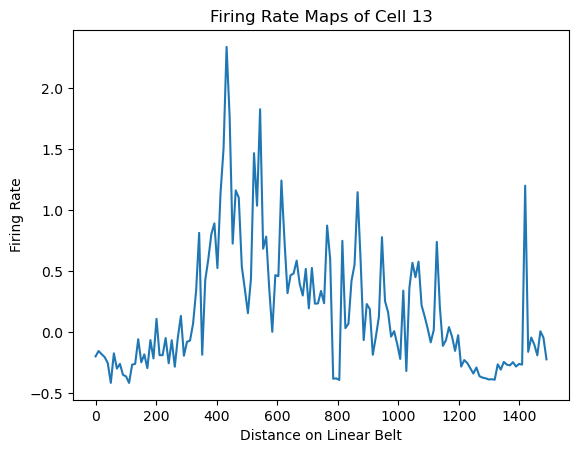

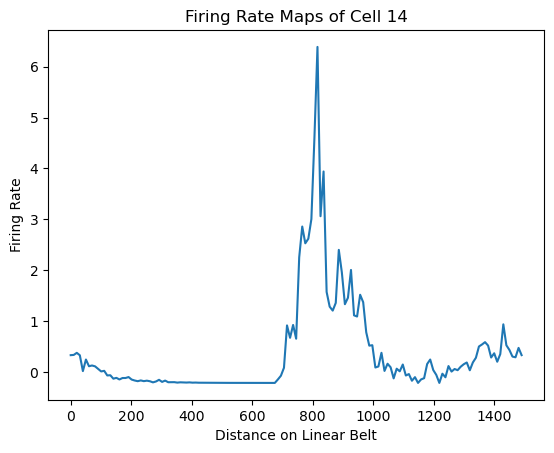

In [27]:
def calculate_avr_firing_rate_map(fluorescence_traces, distance_bins):
    firing_rate_maps = []
    for i in range(len(fluorescence_traces.columns)):
         # Compute histogram with sum of fluorescence values in each bin
        hist, _ = np.histogram(distance, bins=distance_bins, weights=fluorescence_traces.iloc[:, i])
        
        # Compute histogram with count of activations in each bin
        count_hist, _ = np.histogram(distance, bins=distance_bins)
        
        # Calculate average fluorescence value within each bin
        avg_firing_rate_map = np.divide(hist, count_hist, out=np.zeros_like(hist), where=(count_hist != 0))
        
        # Handle NaNs due to zero counts by setting them to zero
        avg_firing_rate_map[np.isnan(avg_firing_rate_map)] = 0
        
        # Append average firing rate map
        firing_rate_maps.append(avg_firing_rate_map)
    
    return np.array(firing_rate_maps)
    


# Define distance bins
distance_bins = np.linspace(distance.min(), distance.max(), num=150)

# Calculate firing rate maps
avr_firing_rate_maps = calculate_avr_firing_rate_map(fluorescence_traces, distance_bins)

avr_firing_rate_maps=avr_firing_rate_maps[cells_with_events]

# Visualize firing rate maps
plt.figure(figsize=(10, 6))
for i in range(15):#len(firing_rate_maps)):
    # Reshape the firing rate map to match the shape of distance_bins[:-1]
    firing_rate_map_i = avr_firing_rate_maps[i].reshape(-1)
    plt.plot(distance_bins[:-1], avr_firing_rate_maps[i], label=f'Cell {i+1}')
    plt.xlabel('Distance on Linear Belt')
    plt.ylabel('Firing Rate')
    plt.title(f'Firing Rate Maps of Cell {i}')
    #plt.legend(loc='lower right')
    plt.show()


In [28]:
len(avr_firing_rate_maps)

328

I only plot the cells with the potential evens here

C:\Users\Theodore Tamiolakis\AppData\Local\Temp\ipykernel_25236\4119652509.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 8))


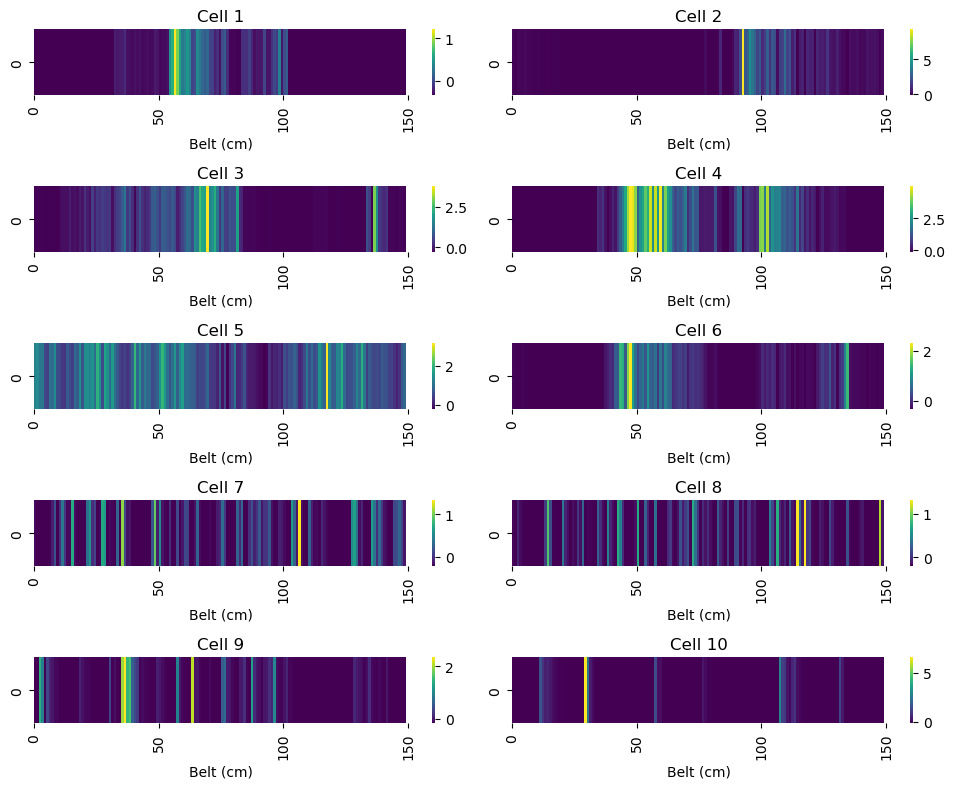

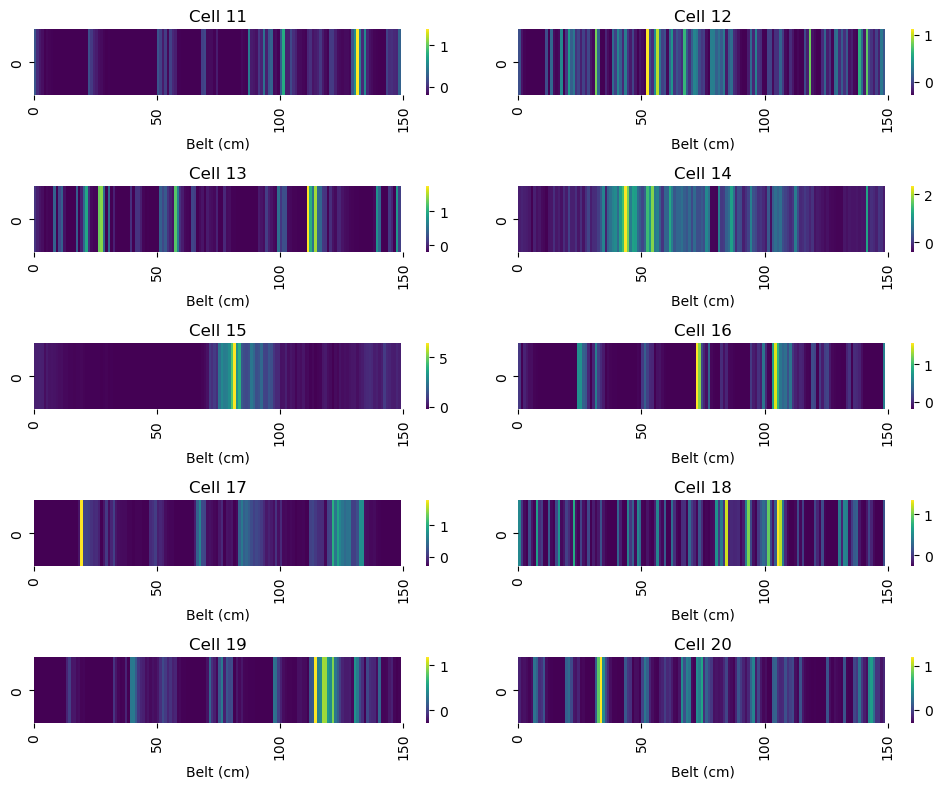

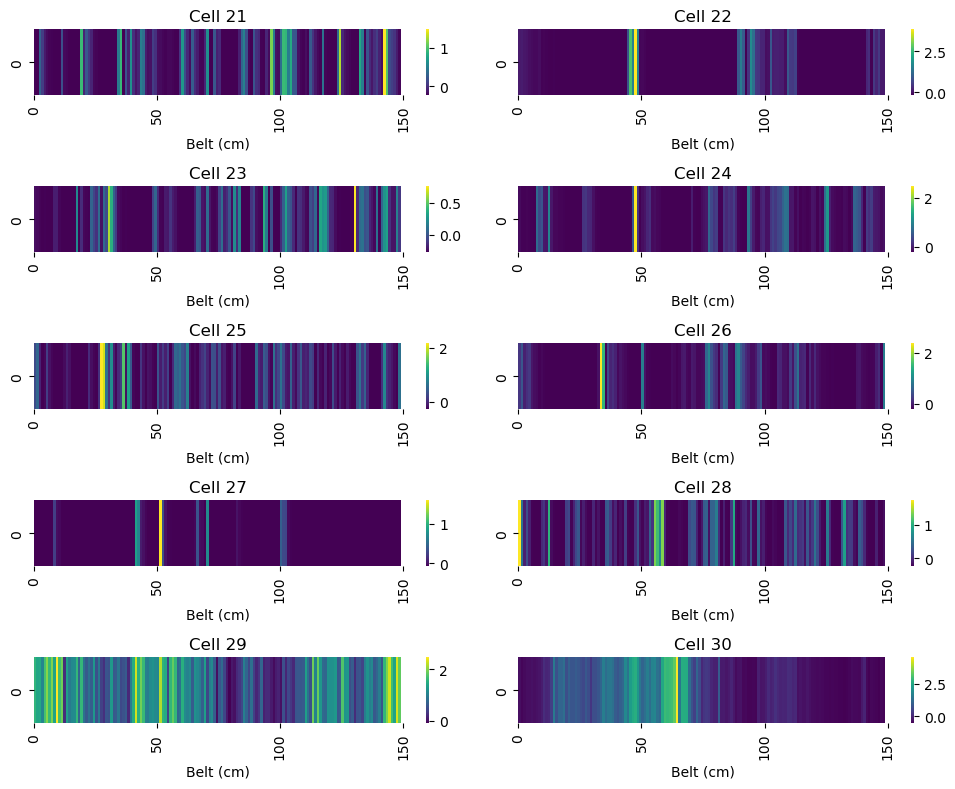

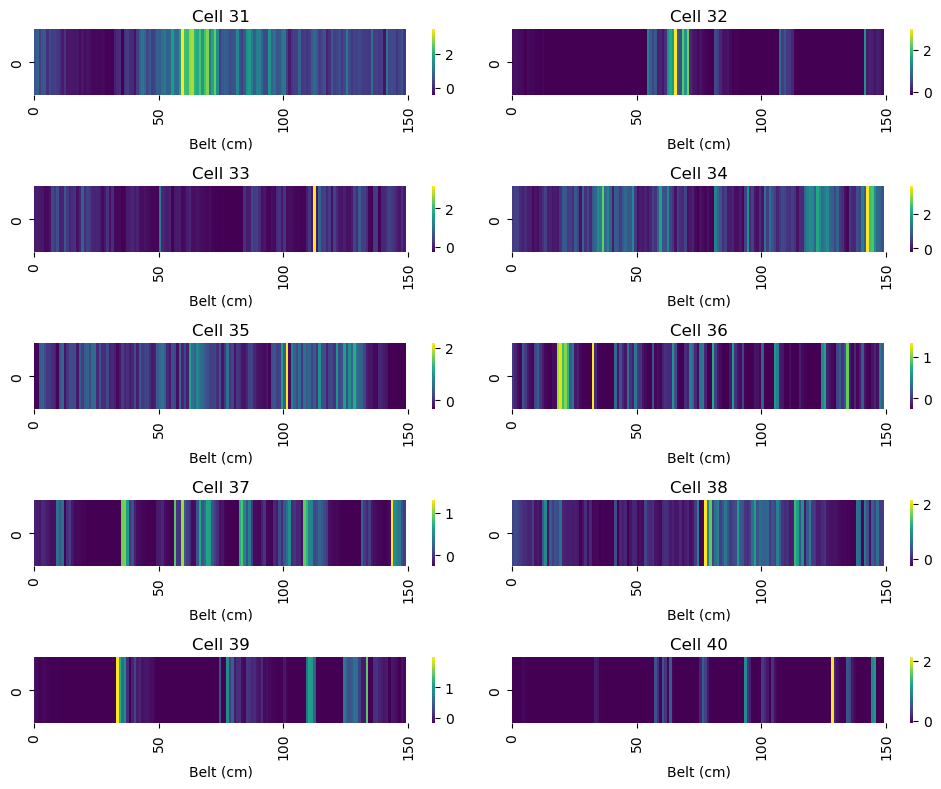

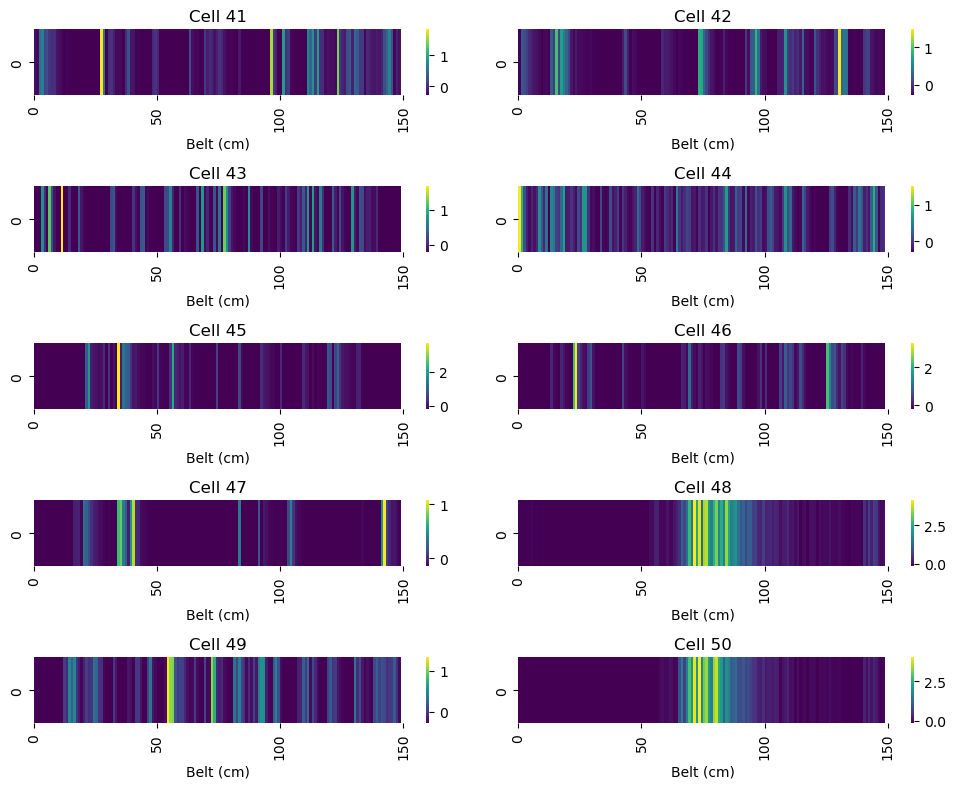

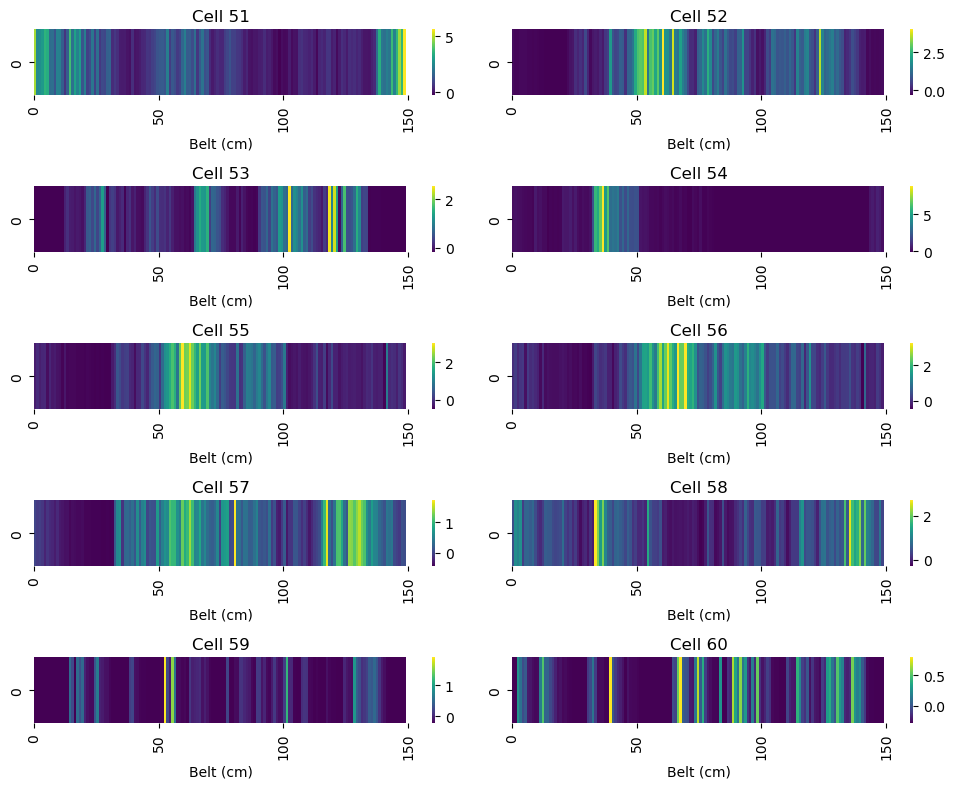

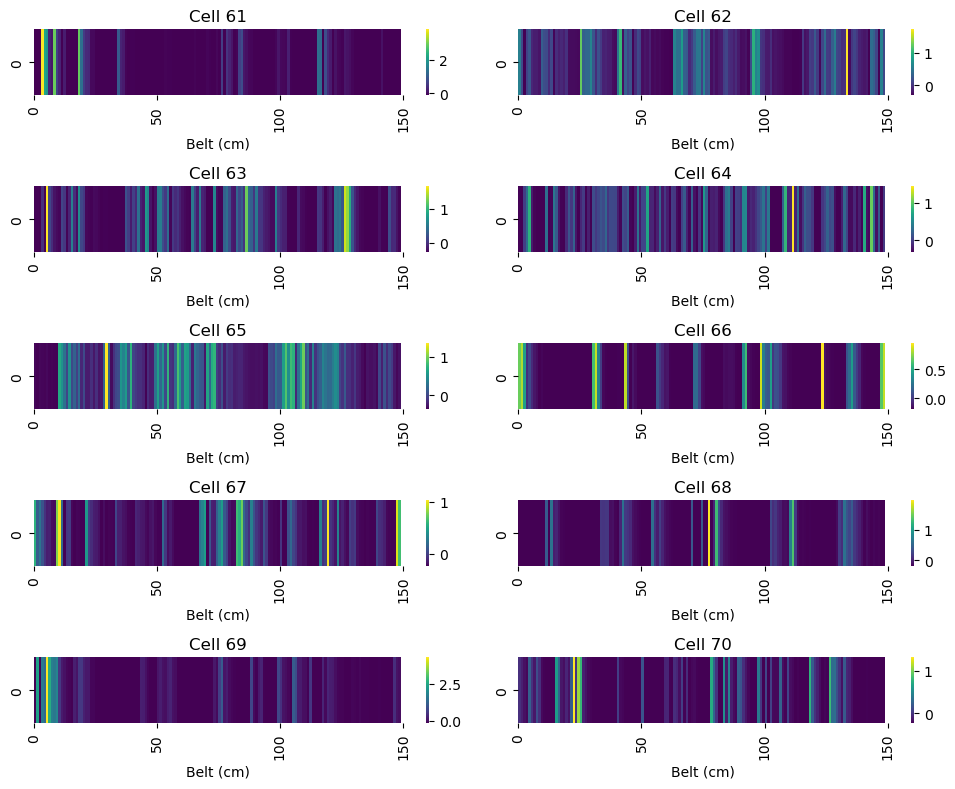

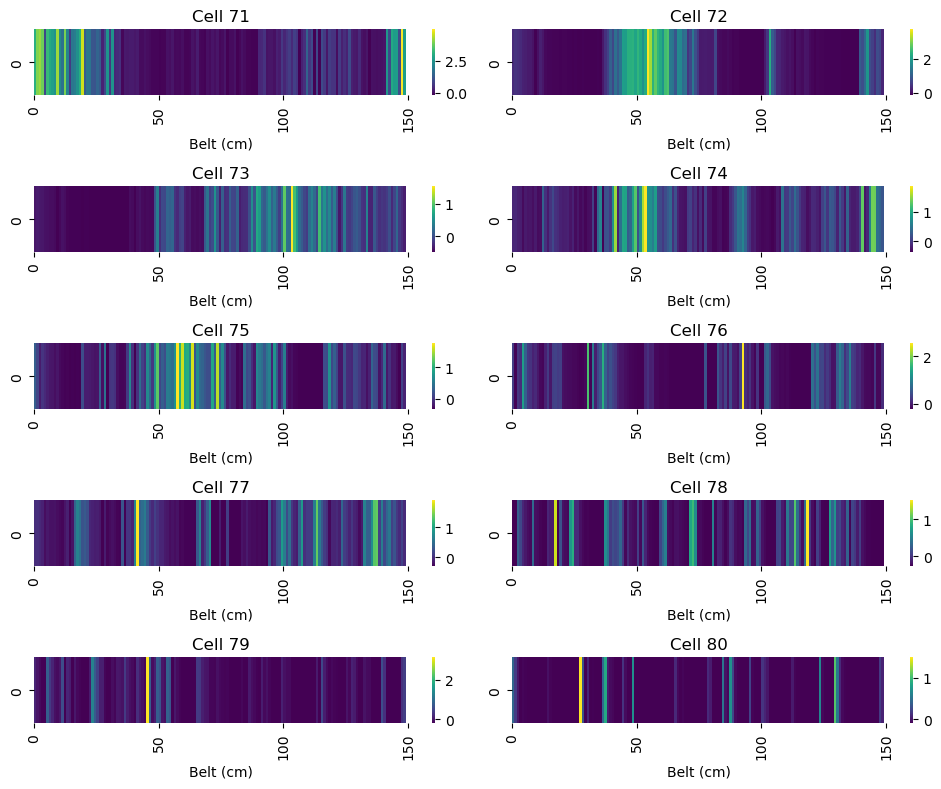

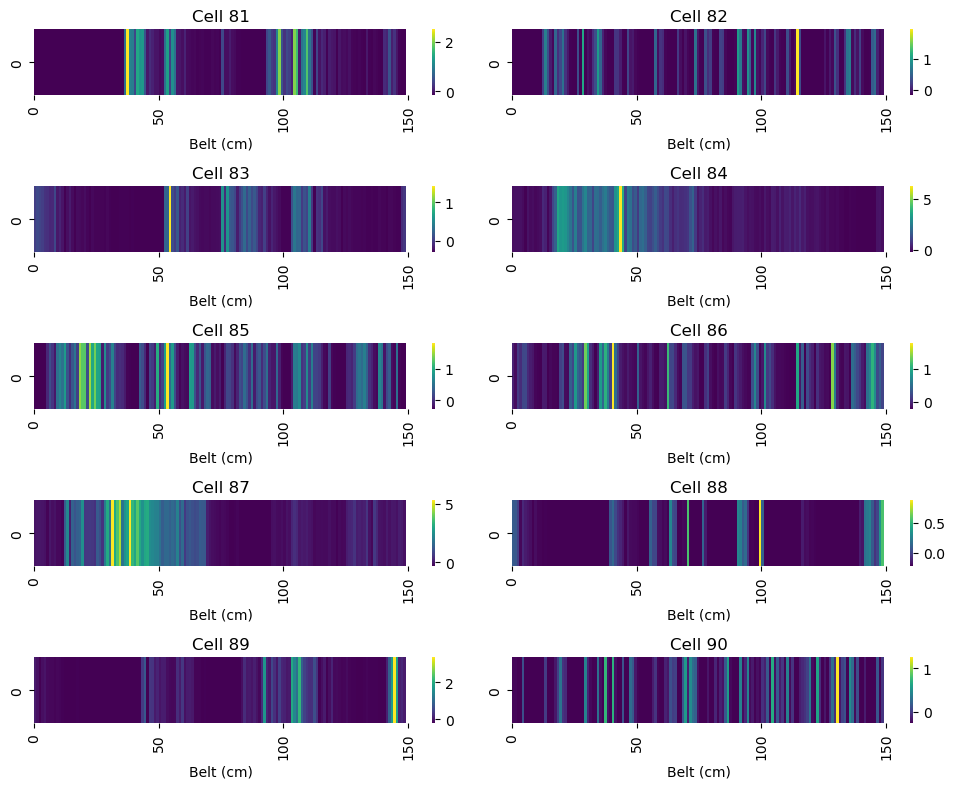

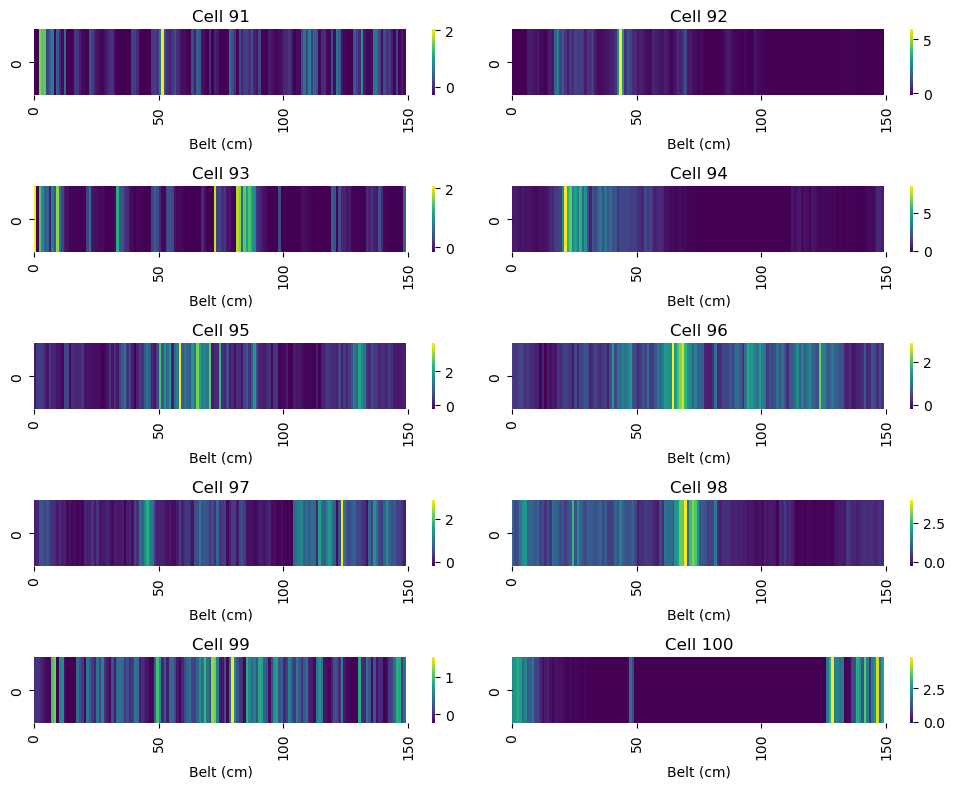

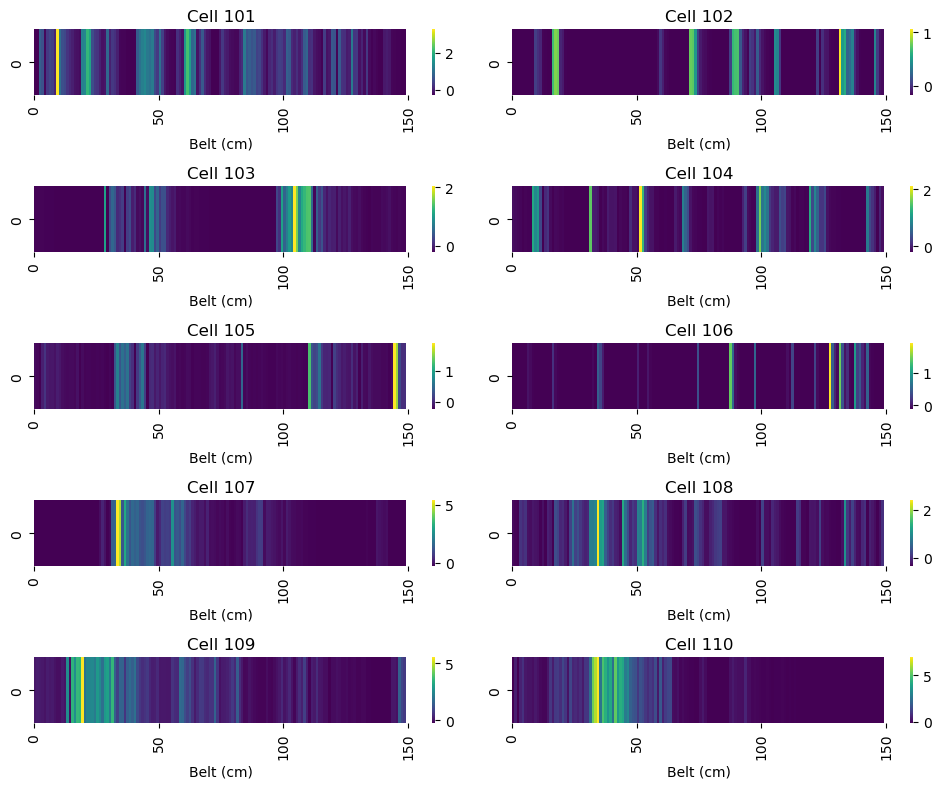

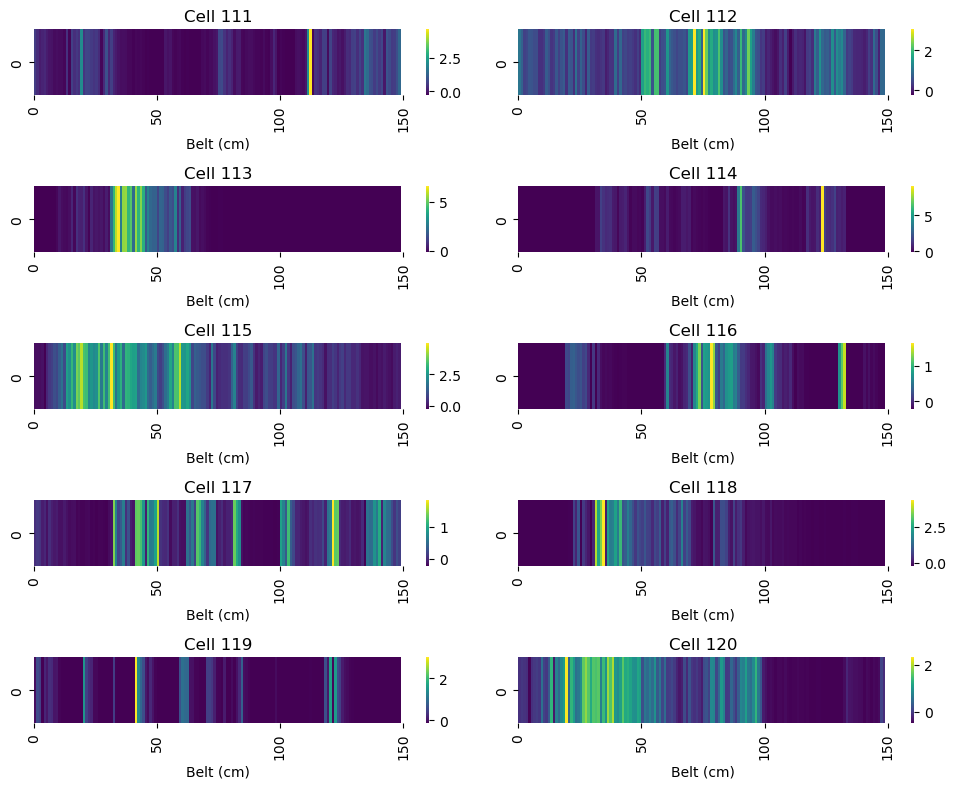

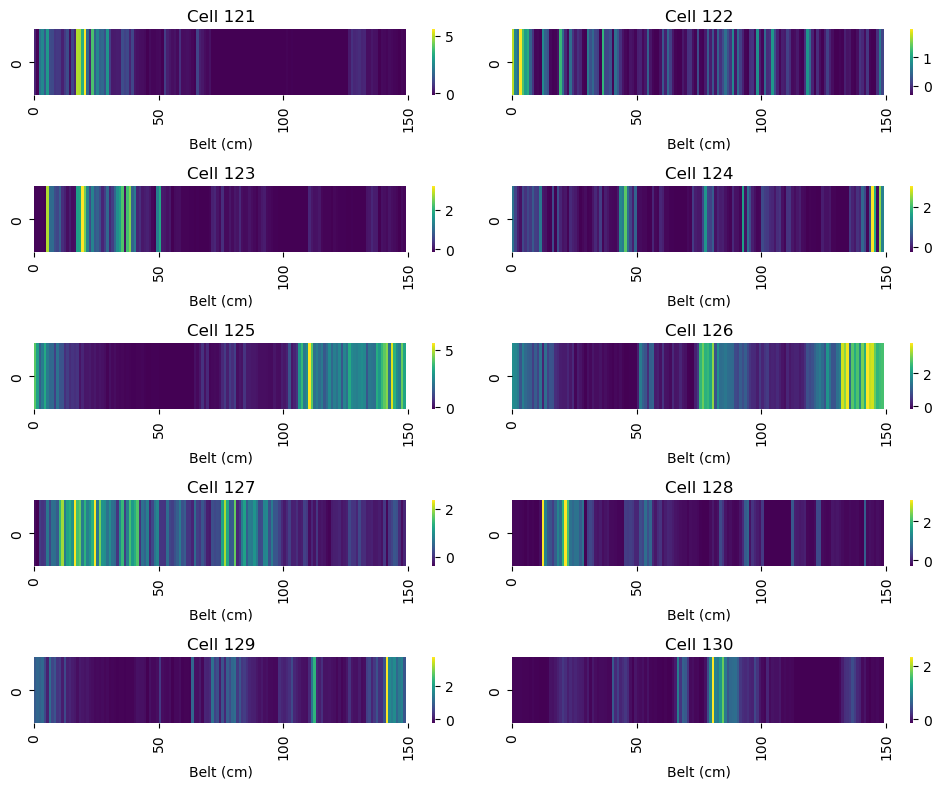

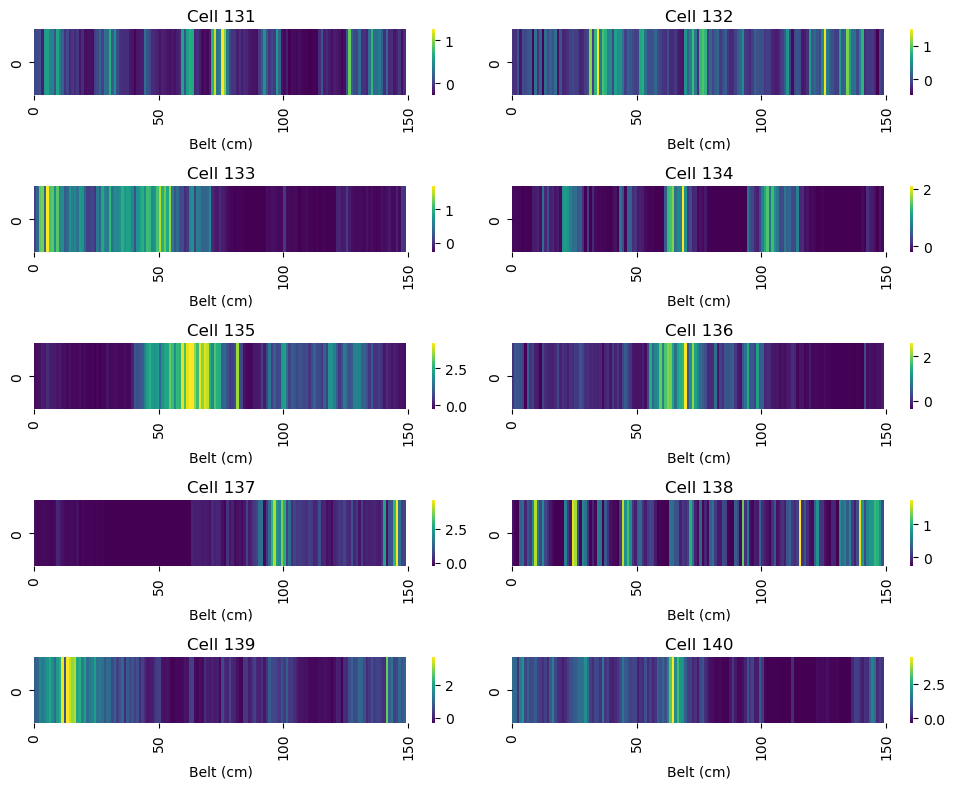

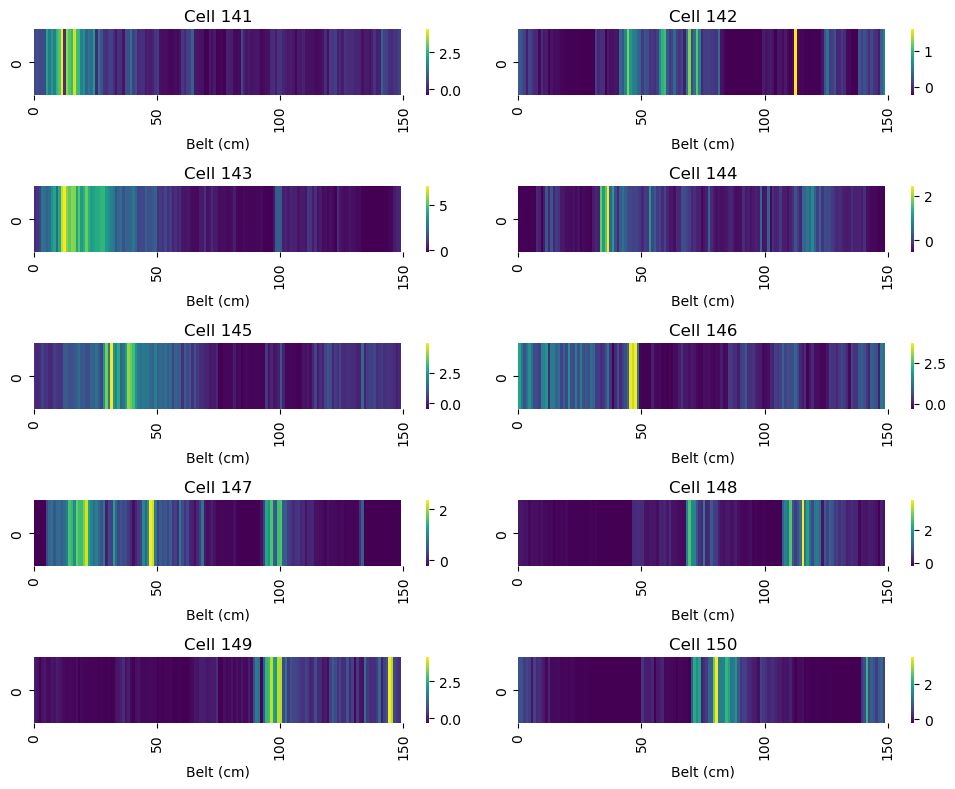

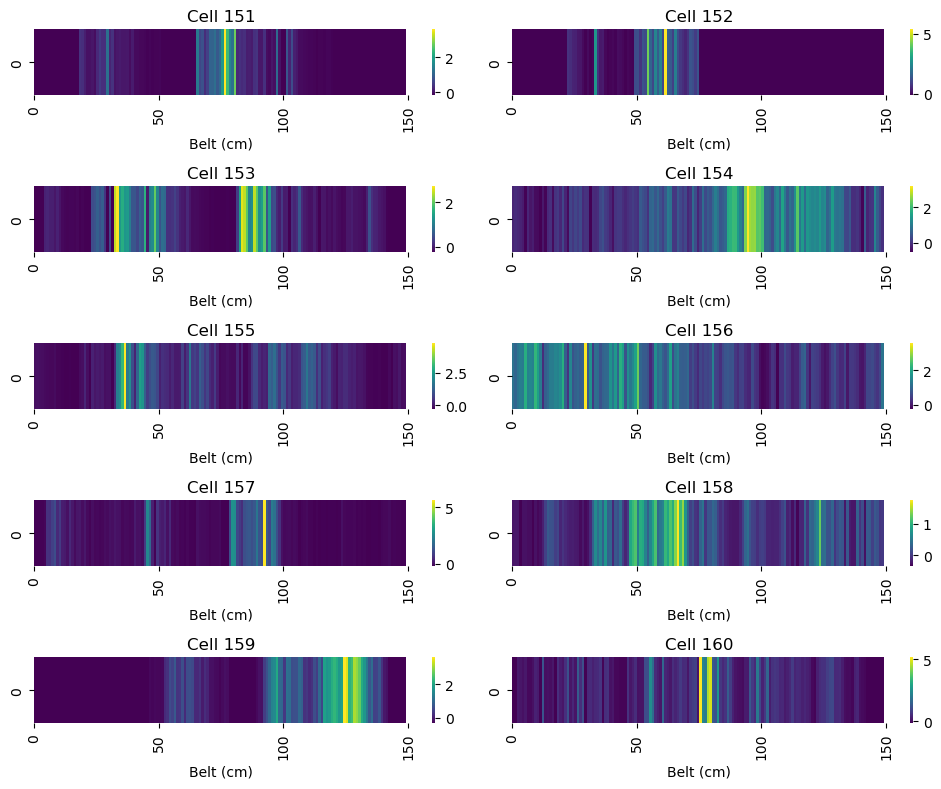

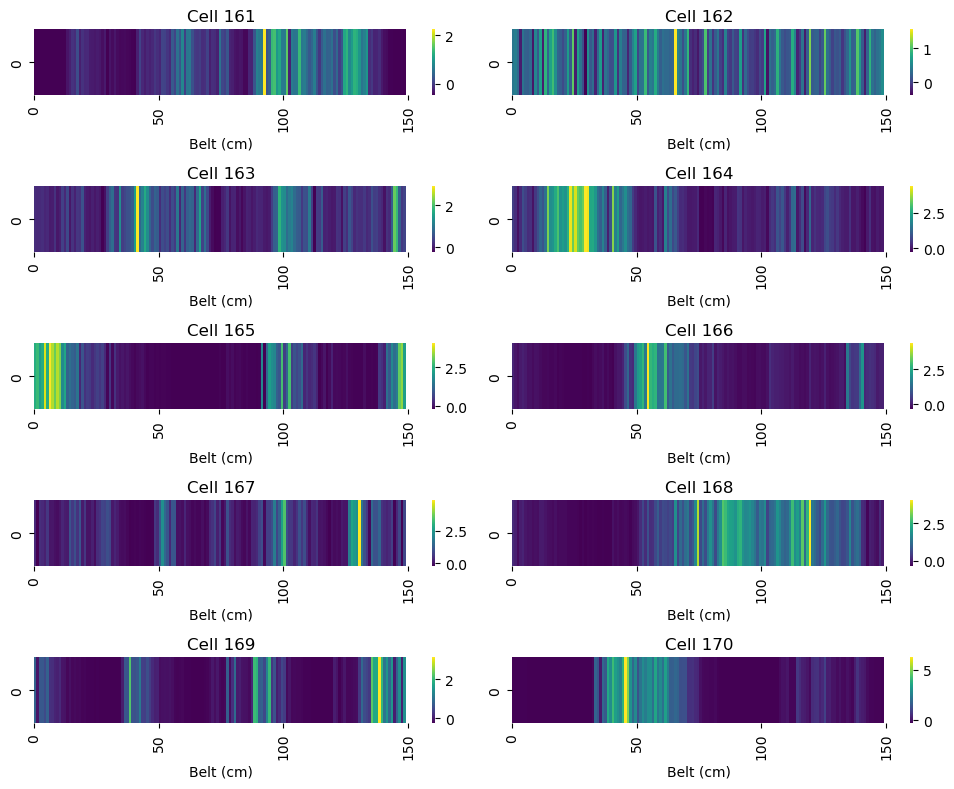

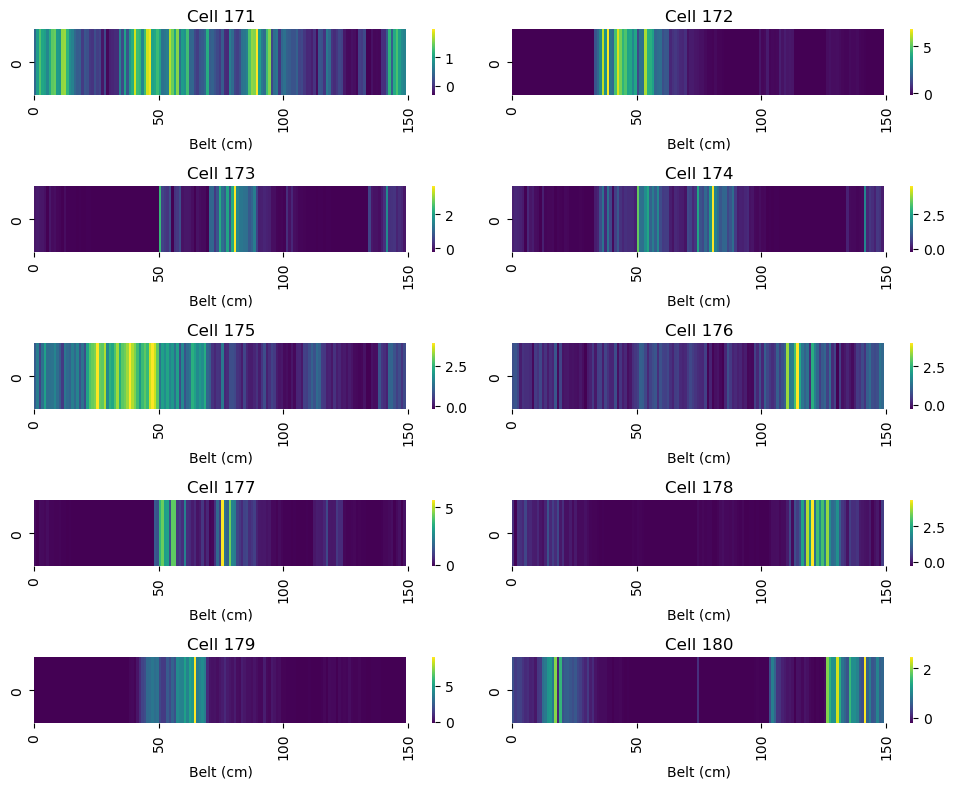

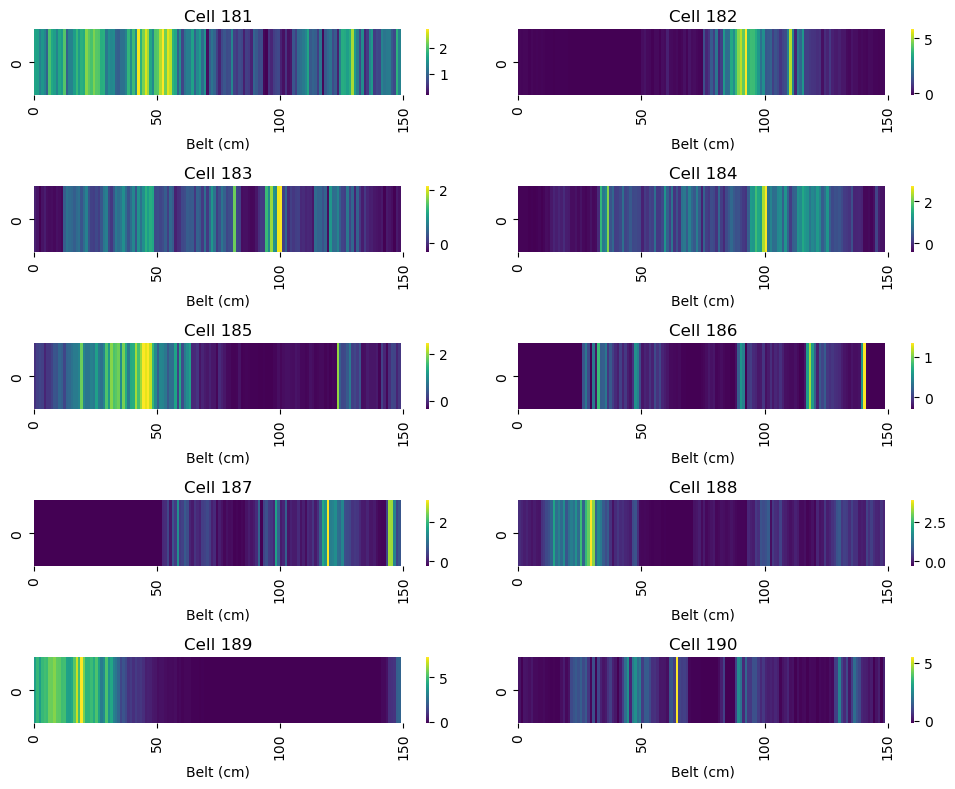

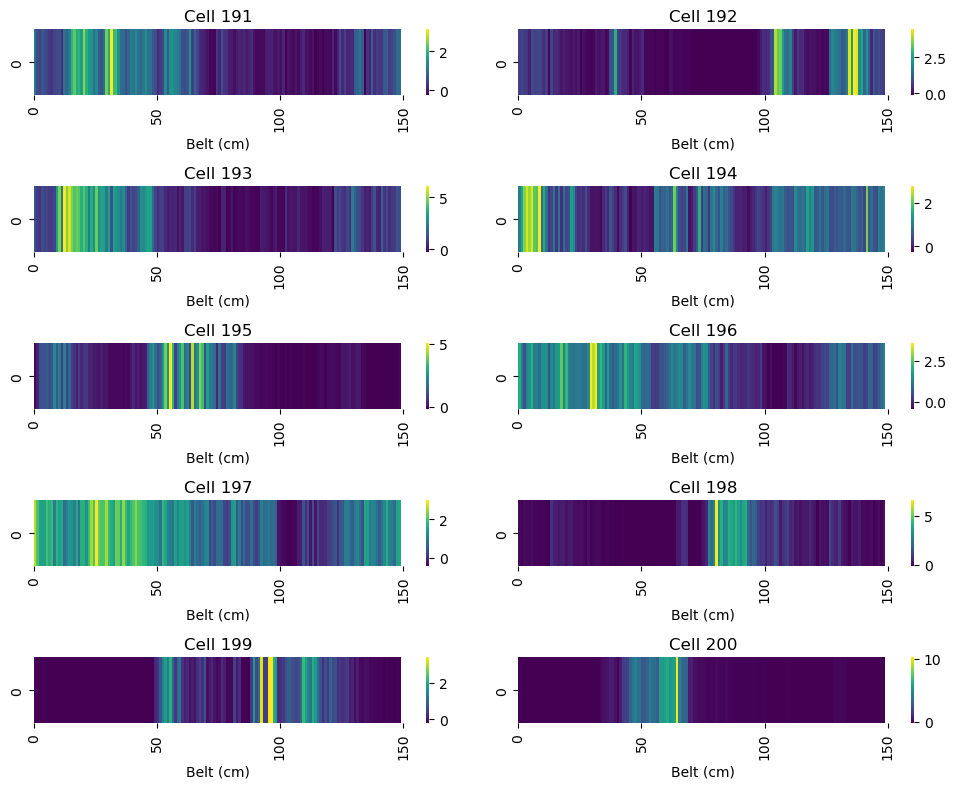

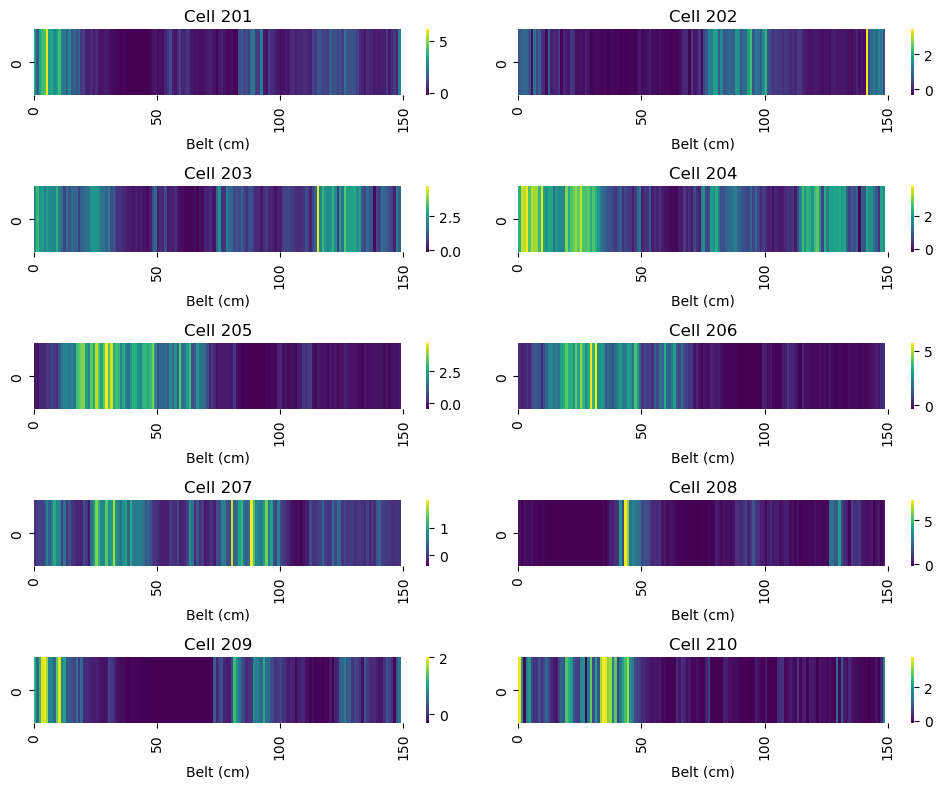

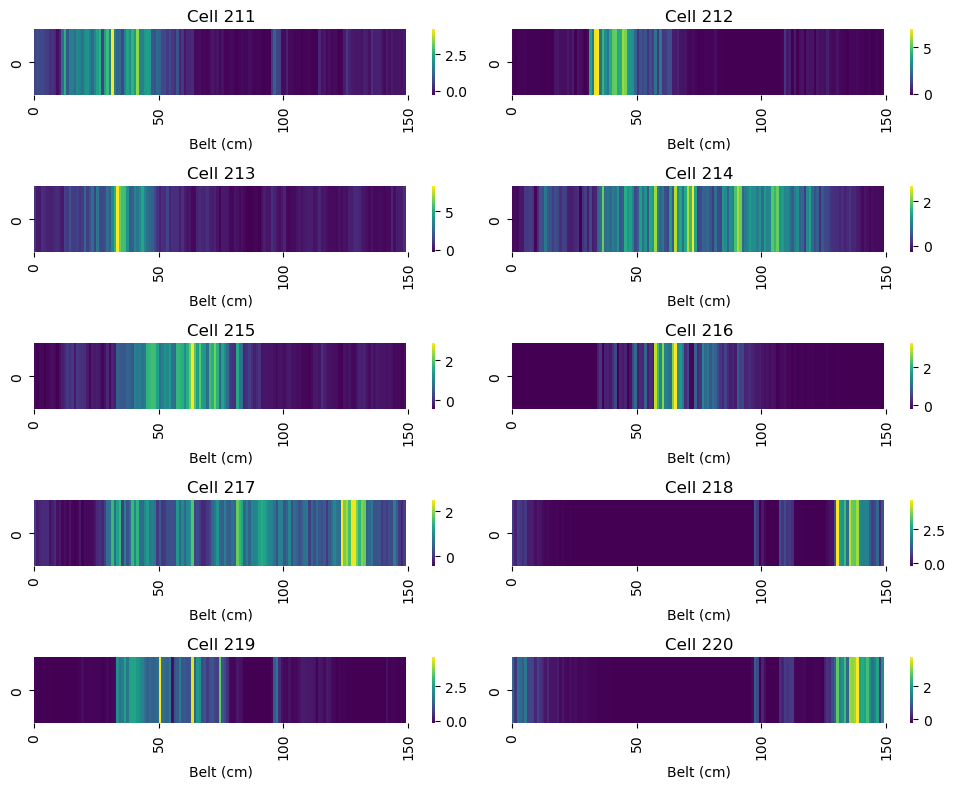

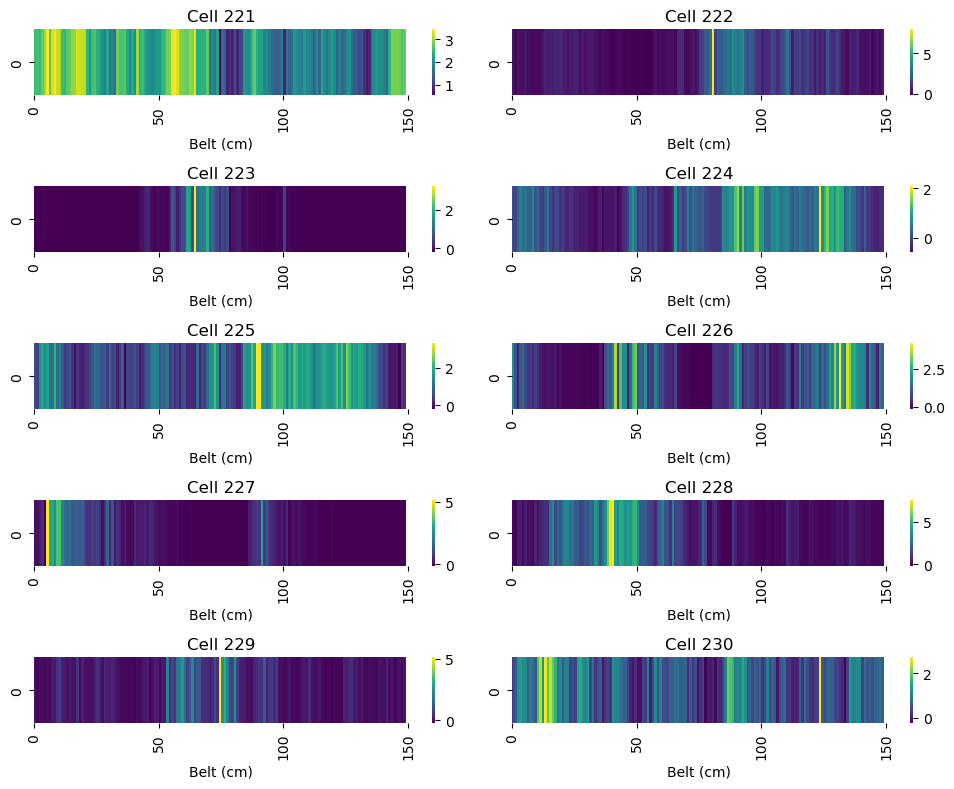

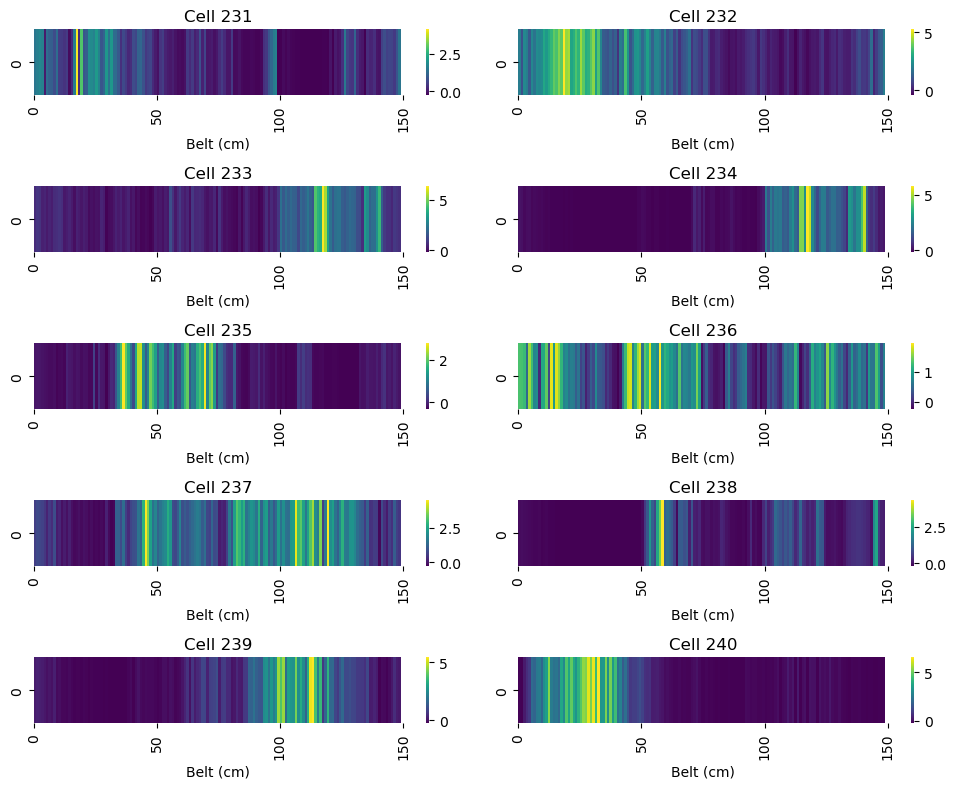

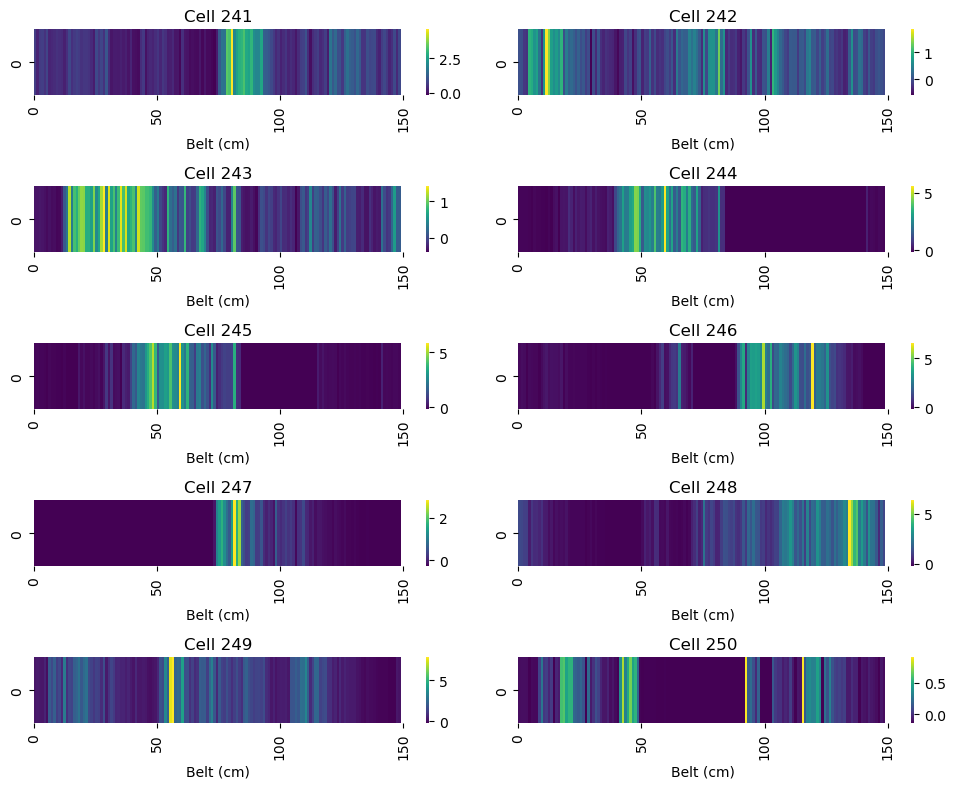

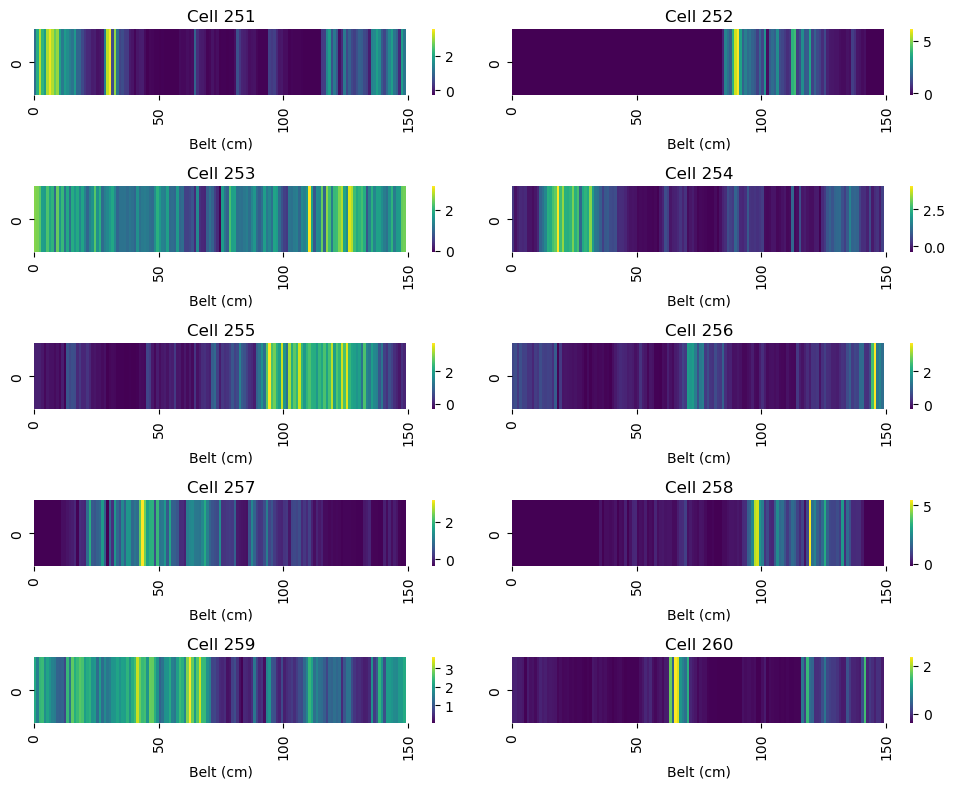

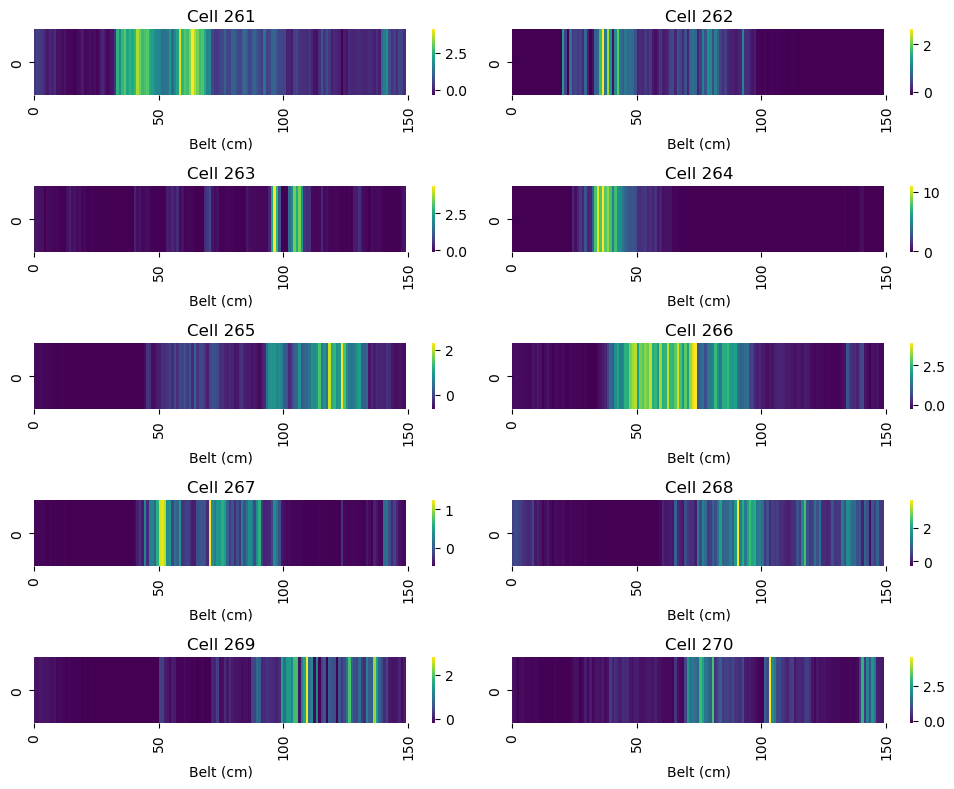

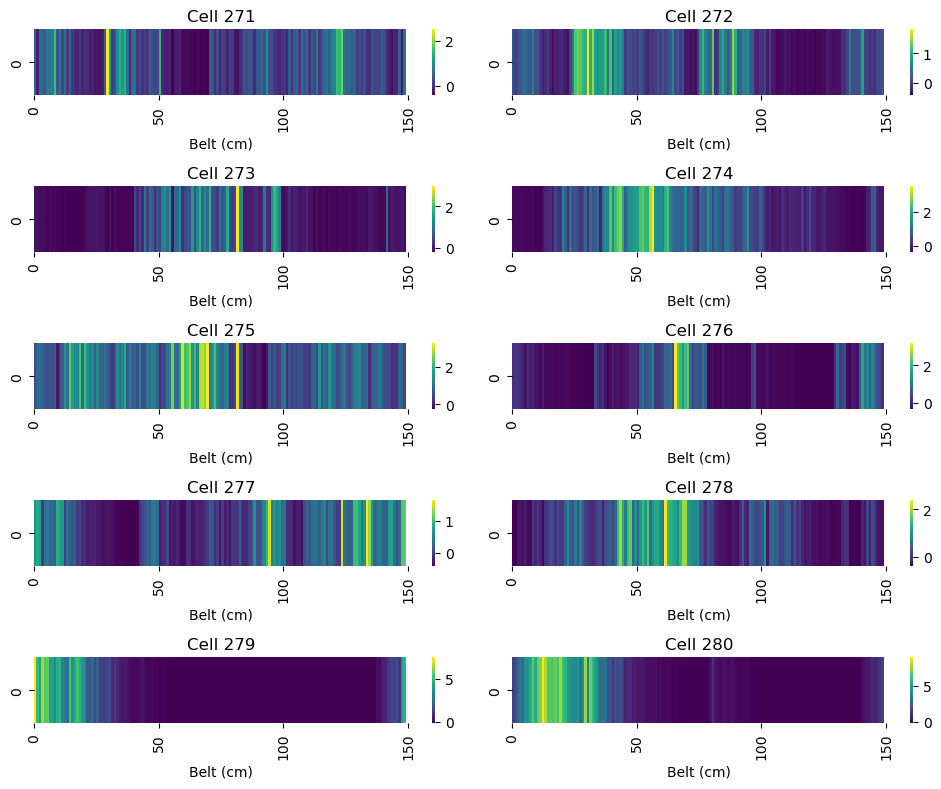

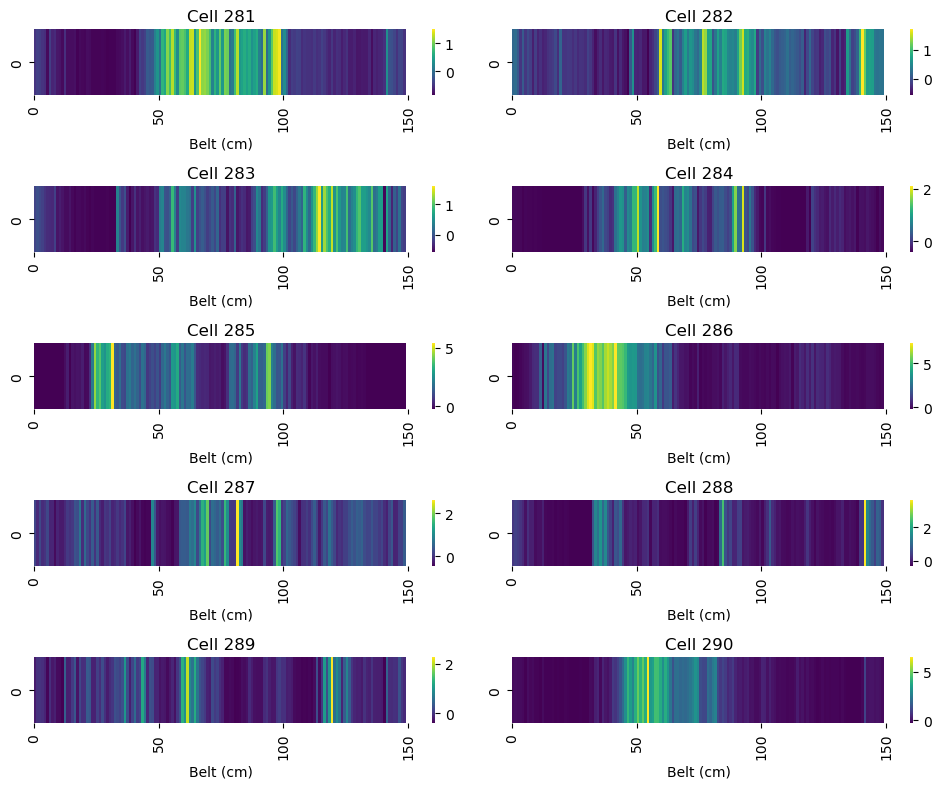

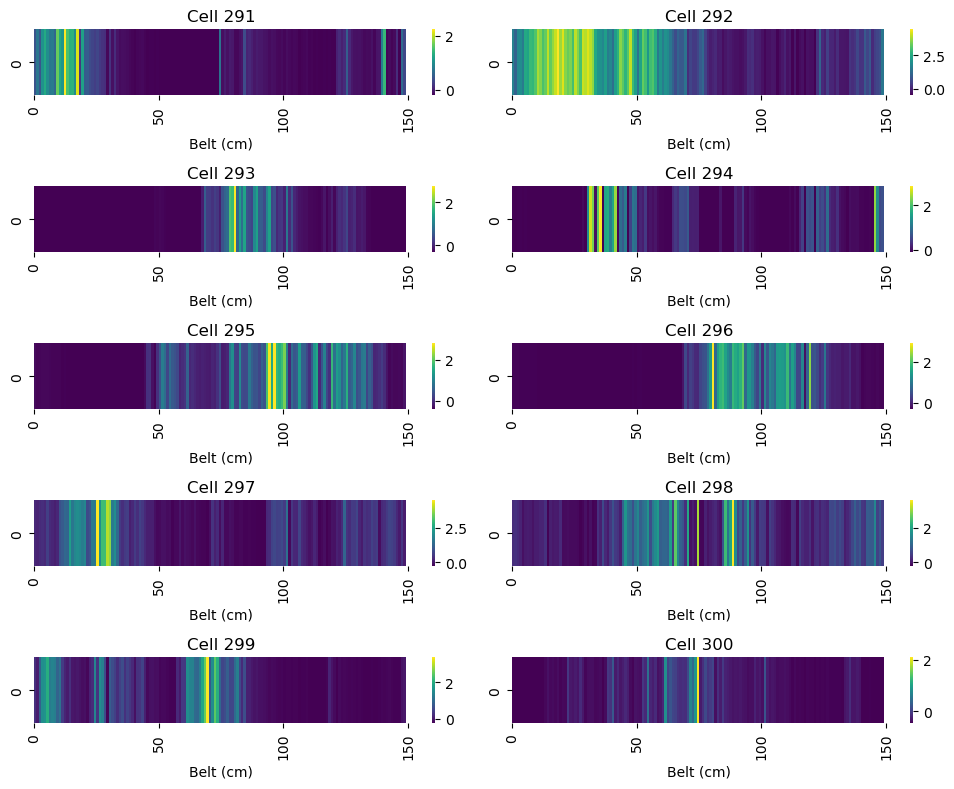

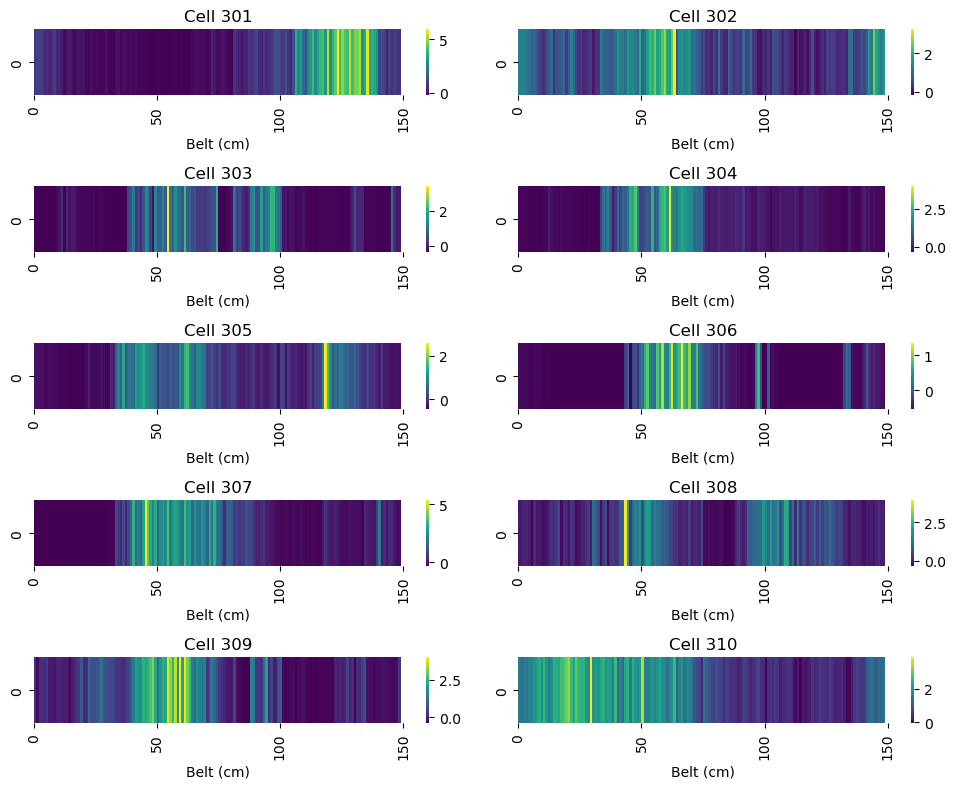

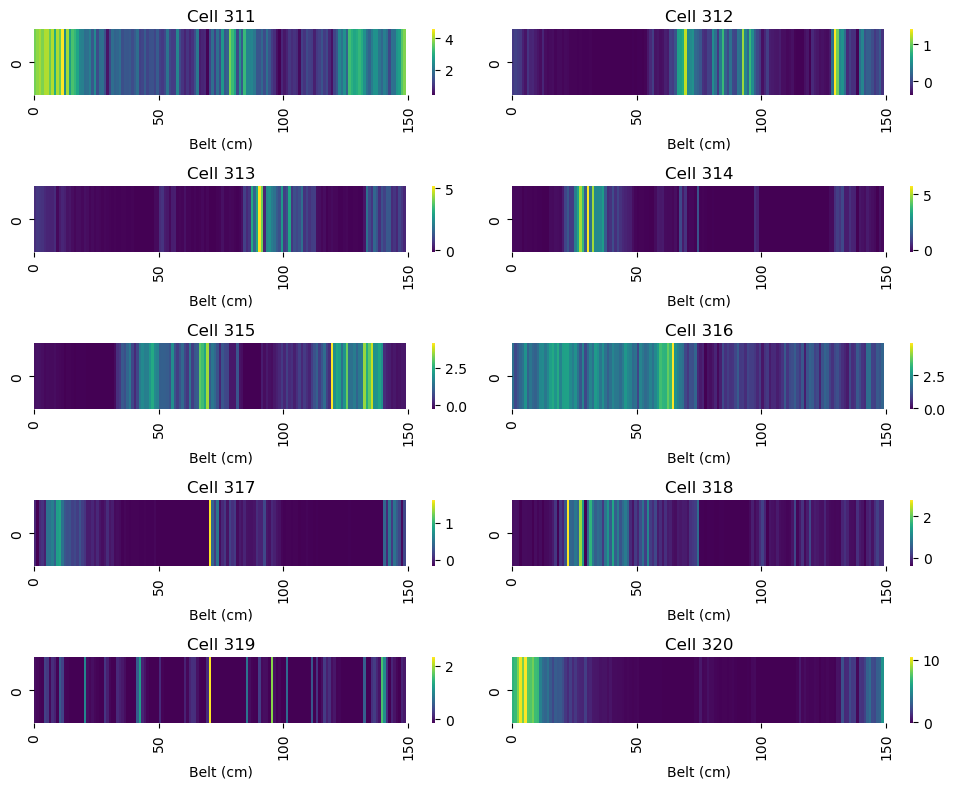

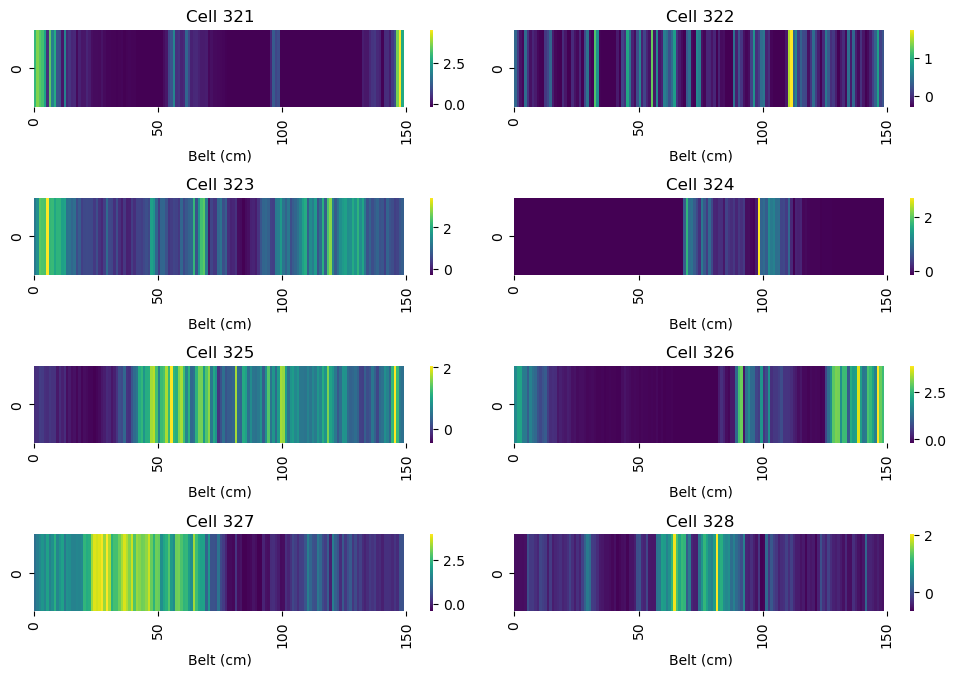

In [29]:
from matplotlib.backends.backend_pdf import PdfPages

# Assuming firing_rate_maps[2] is the data for a single cell's firing rate map
# Set the number of subplots per page
subplots_per_page = 10

# Calculate the number of pages needed
num_pages = int(np.ceil(len(avr_firing_rate_maps) / subplots_per_page))

# Create a PDF file
pdf_pages = PdfPages(results_folder+'heatmap_average_events.pdf')

for page in range(num_pages):
    # Create a new figure for each page
    plt.figure(figsize=(10, 8))

    # Add subplots to the page
    for i in range(subplots_per_page):
        idx = page * subplots_per_page + i
        if idx < len(avr_firing_rate_maps):
            avr_firing_rate_map = np.atleast_2d(avr_firing_rate_maps[idx])
            # Add subplot for the current cell's firing rate map
            plt.subplot(5, 2, i + 1)  # Assuming 20 subplots arranged in 4x5 grid
            sns.heatmap(avr_firing_rate_map, cmap='viridis')
                # Create heatmap using Seaborn with custom x-axis tick labels

            # Calculate tick locations and labels
            tick_locs = np.linspace(0, 150, num=4)
            tick_labels = [int(tick_locs[i]) for i in range(len(tick_locs))]

            # Set custom x-axis tick locations and labels
            plt.xticks(tick_locs, tick_labels)

            # Set labels and title
            plt.xlabel('Belt (cm)')

            plt.title(f'Cell {idx + 1}')

    # Adjust layout and save the page
    plt.tight_layout()
    pdf_pages.savefig()

# Close the PDF file
pdf_pages.close()



Now I need to store the firing rate maps per round so that I plot the spatial tuned vectors later

In [30]:

num_rounds = 7
num_bins = 150
num_cells = 592  # Assuming 592 cells

# Initialize a 3-dimensional array to store firing rate maps for each cell and round
firing_rate_maps = np.zeros((num_cells, num_rounds, num_bins))

for cell in range(num_cells):
    for round_num in range(1, num_rounds + 1):
        round_data = data[data['Rounds'] == round_num]  # Filter data for the current round and cell
        
        # Calculate histogram for the current cell and round with specified number of bins
        hist, _ = np.histogram(round_data['Distance (cm)'], bins=num_bins, weights=round_data[cell])
        
        # Calculate histogram of count of activations in each bin
        count_hist, _ = np.histogram(round_data['Distance (cm)'], bins=num_bins)
        
        # Calculate average firing rate map for the current cell and round
        avg_firing_rate_map = np.divide(hist, count_hist, out=np.zeros_like(hist), where=(count_hist != 0))
        avg_firing_rate_map[np.isnan(avg_firing_rate_map)] = 0
        
        # Store the average firing rate map in the firing_rate_maps array
        firing_rate_maps[cell, round_num - 1] = avg_firing_rate_map




In [31]:
import numpy as np
from scipy.ndimage import gaussian_filter
from scipy.signal import find_peaks
from scipy.stats import ttest_ind

#shifts the array bya  specific number but mainitng the correlation between the numbers

def circular_shift(array,shift):
    return np.roll(arr,shift)   





In [32]:
a=np.arange(7)
np.roll(a,3)

array([4, 5, 6, 0, 1, 2, 3])

In [ ]:
#testing if I can plot the histogram if I have a 3d array with 8 rows for 8 rounds

#this is for fluorescence not for peaks. z score I mean


for cell in range(10):
    test=firing_rate_maps[cell]

    bins=150

    avg_histogram=np.mean(test, axis=0)

    plt.figure(figsize=(10, 6))
    plt.bar(range(bins), avg_histogram, color='blue', alpha=0.7)
    plt.xlabel('Distance in belt (cm)')
    plt.ylabel('Average Count')
    plt.title(f'Histogram of cell {cell} across rounds')

    #then shuffling the initial set of data

    for j in range(2):
        shifted_data=np.zeros_like(test)
        for i in range(test.shape[0]):
            shift=np.random.randint(test.shape[1])
            shifted_data[i]=np.roll(test[i],shift)

        avg_shifted=np.mean(shifted_data,axis=0)
        plt.bar(range(bins),avg_shifted,color='red',alpha=0.7)
    plt.show()




In [ ]:
#testing if I can plot the histogram if I have a 3d array with 8 rows for 8 rounds

#now lets try to do the same but for peaks

def event_numbers(data,threshold,max_distance):
    peaks, _=find_peaks(data, height=threshold,distance=max_distance)

    return data.iloc[peaks]

for cell in range(30):

    bins=150
    test=firing_rate_maps[cell]
    binarized_test=np.zeros_like(test)
    peak_n=0
    for i in range(test.shape[0]):        
        data_per_round=test[i]
        peaks, _=find_peaks(data_per_round, height=2,distance=10)
        peak_n+=len(peaks)
        binarized_test[i][peaks]=1
    total_binarized=binarized_test.sum(axis=0)

    if peak_n>4:
        #plotting the histogram of the cell
        plt.figure(figsize=(10, 6))
        plt.bar(range(bins), total_binarized, color='blue', alpha=1)
        plt.xlabel('Distance in belt (cm)')
        plt.ylabel('Average Count')
        plt.title(f'Histogram of cell {cell} across rounds')

        #shuffling the events and plotting it again

        for j in range(2):
            shifted_data=binarized_test
            for i in range(shifted_data.shape[0]):
                shift=np.random.randint(shifted_data.shape[1])
                shifted_data[i]=np.roll(shifted_data[i],shift)

            sum_shifted_data=shifted_data.sum(axis=0)
            plt.bar(range(bins),sum_shifted_data,color='red',alpha=1)
        plt.show()






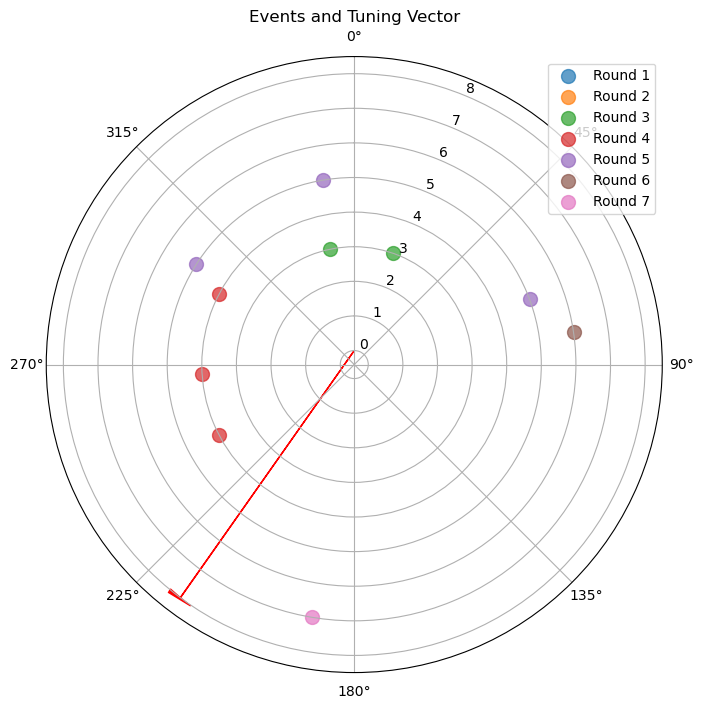

In [35]:
#i will try the tuning vector now. why not?

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Example data (replace with your actual data)
# Assuming you have a pandas DataFrame where each column represents events for a separate bin and rows correspond to rounds
# Example data frame with random events for illustration:
num_bins = 150
num_rounds = 8
angles = np.linspace(0, 2*np.pi, num_bins, endpoint=False)
events_data = binarized_test

def plot_events_and_tuning_vector(events):
    # Create a polar plot with circles representing each round
    plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, projection='polar')
    ax.set_theta_direction(-1)  # Set clockwise direction
    ax.set_theta_zero_location('N')  # Set zero angle at North

    # Plot events on the circle
    for i, events_round in enumerate(events):
        event_angles = angles[np.where(events_round == 1)]
        event_radii = np.ones_like(event_angles) * (i + 1)  # Adjust the radius for each round
        ax.scatter(event_angles, event_radii, s=100, label=f'Round {i+1}', alpha=0.7)

    # Calculate total tuning vector angle
    total_tuning_angle = np.mean(events_data.nonzero()[1]) * (2 * np.pi / num_bins)

    # Plot the total tuning vector as an arrow
    ax.arrow(0, 0, total_tuning_angle, num_rounds, head_width=0.1, head_length=0.1, fc='red', ec='red')

    # Customize plot
    ax.set_title('Events and Tuning Vector')
    ax.legend()
    ax.grid(True)

    plt.show()

# Plot events and tuning vector on the circle
plot_events_and_tuning_vector(events_data)



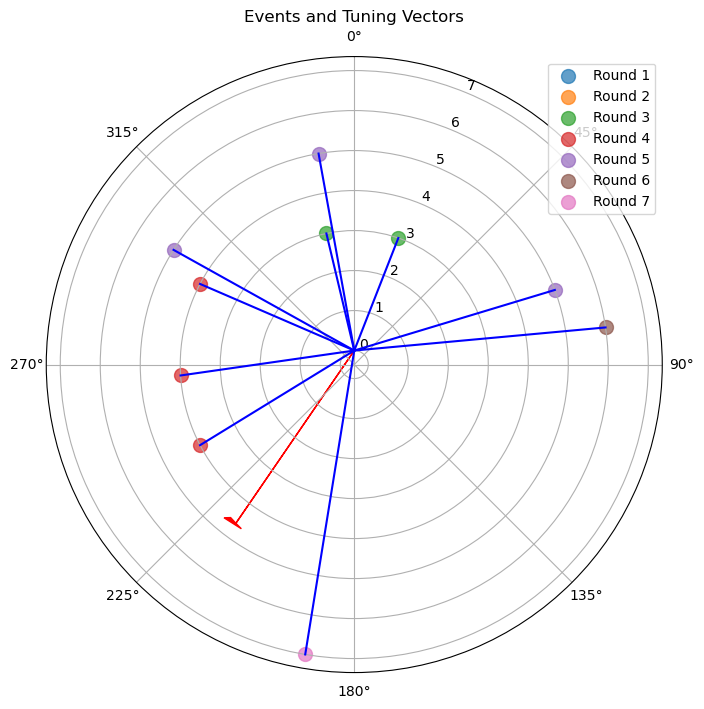

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Example data (replace with your actual data)
# Assuming you have a pandas DataFrame where each column represents events for a separate bin
# and rows correspond to rounds
# Example data frame with random events for illustration:
num_bins = 150
num_rounds = 8
angles = np.linspace(0, 2*np.pi, num_bins, endpoint=False)
events_data = binarized_test  # Assuming you have your actual events data

def plot_events_and_tuning_vectors(events):
    # Create a polar plot with circles representing each round
    plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, projection='polar')
    ax.set_theta_direction(-1)  # Set clockwise direction
    ax.set_theta_zero_location('N')  # Set zero angle at North

    # Plot events on the circle
    for i, events_round in enumerate(events):
        event_angles = angles[np.where(events_round == 1)]
        event_radii = np.ones_like(event_angles) * (i + 1)  # Adjust the radius for each round
        ax.scatter(event_angles, event_radii, s=100, label=f'Round {i+1}', alpha=0.7)

    # Calculate and plot individual tuning vectors
    for i, events_round in enumerate(events):
        event_angles = angles[np.where(events_round == 1)]
        event_radii = np.ones_like(event_angles) * (i + 1)  # Adjust the radius for each round
        for event_angle, event_radius in zip(event_angles, event_radii):
            ax.plot([0, event_angle], [0, event_radius], color='blue')  # Plot individual tuning vector

    # Calculate and plot total tuning vector
    total_tuning_angle = np.mean(events_data.nonzero()[1]) * (2 * np.pi / num_bins)
    total_tuning_radius = np.mean(events_data.nonzero()[0]) + 1  # Adjust the radius
    ax.arrow(0, 0, total_tuning_angle, total_tuning_radius, head_width=0.1, head_length=0.1, fc='red', ec='red')

    # Customize plot
    ax.set_title('Events and Tuning Vectors')
    ax.legend()
    ax.grid(True)

    plt.show()

# Plot events and tuning vectors on the circle
plot_events_and_tuning_vectors(events_data)

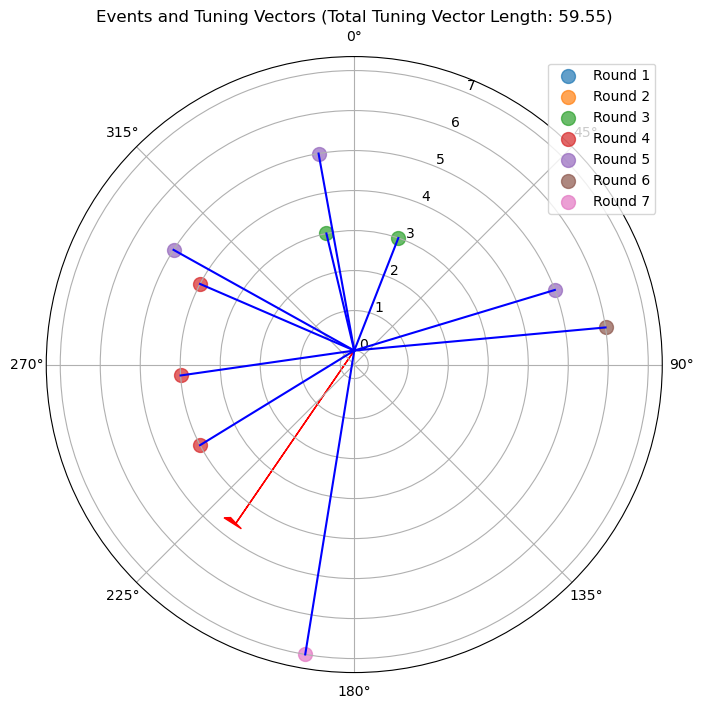

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Example data (replace with your actual data)
# Assuming you have a pandas DataFrame where each column represents events for a separate bin
# and rows correspond to rounds
# Example data frame with random events for illustration:
num_bins = 150
num_rounds = 8
angles = np.linspace(0, 2*np.pi, num_bins, endpoint=False)
events_data = binarized_test  # Assuming you have your actual events data

def plot_events_and_tuning_vectors(events):
    # Create a polar plot with circles representing each round
    plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, projection='polar')
    ax.set_theta_direction(-1)  # Set clockwise direction
    ax.set_theta_zero_location('N')  # Set zero angle at North

    # Plot events on the circle
    for i, events_round in enumerate(events):
        event_angles = angles[np.where(events_round == 1)]
        event_radii = np.ones_like(event_angles) * (i + 1)  # Adjust the radius for each round
        ax.scatter(event_angles, event_radii, s=100, label=f'Round {i+1}', alpha=0.7)

    # Calculate and plot individual tuning vectors
    individual_vectors = []
    for i, events_round in enumerate(events):
        event_angles = angles[np.where(events_round == 1)]
        event_radii = np.ones_like(event_angles) * (i + 1)  # Adjust the radius for each round
        for event_angle, event_radius in zip(event_angles, event_radii):
            individual_vectors.append([event_angle, event_radius])
            ax.plot([0, event_angle], [0, event_radius], color='blue')  # Plot individual tuning vector

 # Calculate and plot total tuning vector
    total_tuning_vector = np.sum(np.array(individual_vectors), axis=0)
    total_tuning_length = np.linalg.norm(total_tuning_vector)
    scaling_factor = 0.1  # Adjust the scaling factor as needed
    scaled_total_tuning_vector = total_tuning_vector * scaling_factor
    ax.arrow(0, 0, scaled_total_tuning_vector[0], scaled_total_tuning_vector[1], head_width=0.1, head_length=0.1, fc='red', ec='red')

    # Customize plot
    ax.set_title('Events and Tuning Vectors (Total Tuning Vector Length: {:.2f})'.format(total_tuning_length))
    ax.legend()
    ax.grid(True)

    plt.show()

# Plot events and tuning vectors on the circle
plot_events_and_tuning_vectors(events_data)

TypeError: only size-1 arrays can be converted to Python scalars

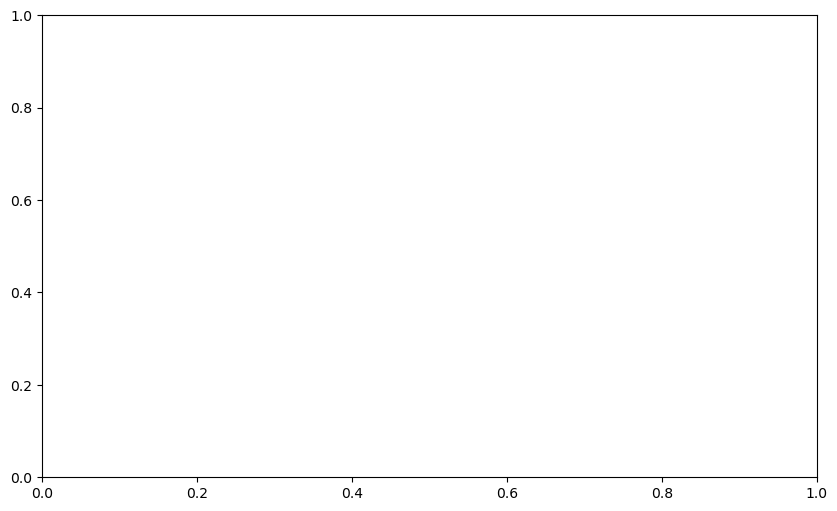

In [37]:
plt.figure(figsize=(10, 6))
plt.bar(range(bins), binarized_test, color='blue', alpha=0.7)
plt.xlabel('Distance in belt (cm)')
plt.ylabel('Average Count')
plt.title(f'Histogram of cell {cell} across rounds')

#then shuffling the initial set of data

for j in range(2):
    shifted_data=np.zeros_like(test)
    for i in range(test.shape[0]):
        shift=np.random.randint(test.shape[1])
        shifted_data[i]=np.roll(test[i],shift)

    avg_shifted=np.mean(shifted_data,axis=0)
    plt.bar(range(bins),avg_shifted,color='red',alpha=0.7)
plt.show()

In [ ]:
# Assuming num_rounds, num_cells, distance_bins, and firing_rate_maps are defined elsewhere

# Initialize a 3-dimensional array to store spatial tuning vectors for each cell and round
spatial_tuning_vectors = np.zeros((num_cells, num_rounds, num_bins - 1))

for cell in range(num_cells):
    for round_num in range(num_rounds):
        # Extract firing rate map for the current cell and round
        firing_rate_map = firing_rate_maps[cell, round_num]
        
        # Compute the gradient of the firing rate map
        gradient = np.gradient(firing_rate_map)
        
        # Calculate the spatial tuning vector using arctan2
        tuning_vector = np.arctan2(gradient[0], gradient[1])
        
        # Store the spatial tuning vector in the spatial_tuning_vectors array
        spatial_tuning_vectors[cell, round_num] = tuning_vector

In [ ]:
# Assuming spatial_tuning_vectors and distance_bins are defined

# Define the number of cells and rounds
num_cells = spatial_tuning_vectors.shape[0]
num_rounds = spatial_tuning_vectors.shape[1]

# Define angles for each distance bin
angles = np.linspace(0, 2 * np.pi, len(distance_bins) - 1)

for cell in range(10):
    # Create a polar plot
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 8))

    # Plot concentric circles for each round
    for r in range(num_rounds):
        ax.plot(angles, np.ones_like(angles) * r, color='gray', linestyle='--', linewidth=0.5)

    # Plot tuning vectors
    for r in range(num_rounds):
        ax.plot(angles, spatial_tuning_vectors[cell, r], label=f'Round {r + 1}')

    # Set the title and legend
    ax.set_title(f'Spatial Tuning Vectors of Cell {cell + 1}')
    ax.legend()

    # Show the plot
    plt.show()

NameError: name 'spatial_tuning_vectors' is not defined

In [ ]:
round1_max=round1.apply(np.argmax,axis=1)
test_filtered = round1.loc[round1_max >= 0]
filtered_values=test_filtered.apply(np.argmax, axis=1).sort_values().index
test_filtered_sorted = test_filtered.loc[list(filtered_values),:]
# Calculate the maximum diagonal values
sns.heatmap(test_filtered_sorted,vmax=20,xticklabels=[])